Refference

https://entreprenerdly.com/top-36-moving-averages-methods-for-stock-prices-in-python/
Top 36 Moving Averages Methods For Stock Prices In Python

Transformers vs. LSTM for Stock Price Time Series Prediction 
https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782

Prediction of Stock Price Time Series using Transformers Lorenzo D. Costa1, Alexei M. C. Machado August 2023
https://www.researchgate.net/publication/372947061_Prediction_of_Stock_Price_Time_Series_using_Transformers

Stock Price Forecast: Comparison of LSTM, HMM, and Transformer Qianzhun Wang1(B) and Yingqing Yuan2
https://www.researchgate.net/publication/372632831_Stock_Price_Forecast_Comparison_of_LSTM_HMM_and_Transformer


https://www.kaggle.com/code/miljan/stock-predictions-with-multi-head-attention/notebook

In [11]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [12]:
dataset = yf.download('NDX', start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'),
                      progress=False,
                      period="ytd", interval="1d")
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset

Date          Open          High           Low         Close  \
0    2020-02-11   9517.860352   9517.860352   9517.860352   9517.860352   
1    2020-02-12   9613.200195   9613.200195   9613.200195   9613.200195   
2    2020-02-13   9595.700195   9595.700195   9595.700195   9595.700195   
3    2020-02-14   9623.580078   9623.580078   9623.580078   9623.580078   
4    2020-02-18   9629.799805   9629.799805   9629.799805   9629.799805   
...         ...           ...           ...           ...           ...   
1065 2024-07-19  19522.619141  19522.619141  19522.619141  19522.619141   
1066 2024-07-22  19822.869141  19822.869141  19822.869141  19822.869141   
1067 2024-07-23  19754.339844  19754.339844  19754.339844  19754.339844   
1068 2024-07-24  19032.390625  19032.390625  19032.390625  19032.390625   
1069 2024-07-25  18830.580078  18830.580078  18830.580078  18830.580078   

         Adj Close  Volume  
0      9517.860352       0  
1      9613.200195       0  
2      9595.700195       0  
3      9623.580078       0  
4      9629.799805       0  
...            ...     ...  
1065  19522.619141       0  
1066  19822.869141       0  
1067  19754.339844       0  
1068  19032.390625       0  
1069  18830.580078       0  

[1070 rows x 7 columns]

In [13]:
len(dataset)

1070

In [50]:
# Fractal Adaptive Moving Average (FRAMA)
def fetch_data(ticker_symbol, start_date, end_date):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data


def calculate_FRAMA(data, batch=10):
    # Input
    InputPrice = data['Close'].values

    Length = len(InputPrice)
    Filt = np.array(InputPrice)

    # Sequentially calculate all variables and the output
    for i in range(2 * batch, Length):

        # Take 2 batches of the input
        v1 = InputPrice[i-2*batch:i - batch]
        v2 = InputPrice[i - batch:i]

        # For the 1st batch calculate N1
        H1 = np.max(v1)
        L1 = np.min(v1)
        N1 = (H1 - L1) / batch

        # For the 2nd batch calculate N2
        H2 = np.max(v2)
        L2 = np.min(v2)
        N2 = (H2 - L2) / batch

        # For both batches calculate N3
        H = np.max([H1, H2])
        L = np.min([L1, L2])
        N3 = (H - L) / (2 * batch)

        # Calculate fractal dimension
        Dimen = 0
        if N1 > 0 and N2 > 0 and N3 > 0:
            Dimen = (np.log(N1 + N2) - np.log(N3)) / np.log(2)

        # Calculate lowpass filter factor
        alpha = np.exp(-4.6 * (Dimen) - 1)
        # Ensuring alpha stays between 0.1 and 1
        alpha = np.clip(alpha, 0.1, 1)

        # Filter the input data
        Filt[i] = alpha * InputPrice[i] + (1 - alpha) * Filt[i-1]

    data['FRAMA'] = Filt
    return data


dataset = calculate_FRAMA(dataset)

# Zero Lag Exponential Moving Average (ZLEMA)


def calculate_EMA(prices, period):
    alpha = 2 / (period + 1)
    EMA = [prices[0]]
    for price in prices[1:]:
        EMA.append((price - EMA[-1]) * alpha + EMA[-1])
    return EMA


def calculate_ZLEMA(prices, period):
    prices = pd.Series(prices)  # Ensure prices is a pandas Series
    lag = period // 2
    adjusted_prices = [
        2 * prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))
    ]
    adjusted_prices = pd.Series(adjusted_prices)
    zlema = adjusted_prices.ewm(span=period, adjust=False).mean()
    return zlema


zlema_period = 28
dataset['ZLEMA'] = calculate_ZLEMA(dataset['Close'].tolist(), zlema_period)

# Variable Index Dynamic Average (VIDYA)


def calculate_CMO(prices, period):
    """ Calculate Chande Momentum Oscillator (CMO) """
    deltas = np.diff(prices)
    sum_gains = np.cumsum(np.where(deltas >= 0, deltas, 0))
    sum_losses = np.abs(np.cumsum(np.where(deltas < 0, deltas, 0)))

    cmo = 100 * (sum_gains - sum_losses) / (sum_gains + sum_losses)
    return np.insert(cmo, 0, 0)  # Add a zero at the beginning for alignment


def calculate_VIDYA(prices, period):
    cmo_values = calculate_CMO(prices, period)
    vidya = [prices[0]]

    for i in range(1, len(prices)):
        alpha = abs(cmo_values[i]) / 100  # Normalize CMO to [0, 1]
        vidya.append((1 - alpha) * vidya[-1] + alpha * prices[i])

    return vidya


vidya_period = 14
dataset['VIDYA'] = calculate_VIDYA(dataset['Close'].tolist(), vidya_period)

# Arnaud Legoux Moving Average (ALMA)


def calculate_ALMA(prices, period, offset=0.85, sigma=6):
    m = np.floor(offset * (period - 1))
    s = period / sigma
    alma = []

    for i in range(period - 1, len(prices)):
        weights = [np.exp(- (j - m)**2 / (2 * s * s)) for j in range(period)]
        sum_weights = sum(weights)
        normalized_weights = [w/sum_weights for w in weights]

        window = prices[i-period+1:i+1]
        alma_value = sum([normalized_weights[j] * window[j]
                         for j in range(period)])
        alma.append(alma_value)

    return [None]*(period-1) + alma


alma_period = 36
dataset['ALMA'] = calculate_ALMA(dataset['Close'].tolist(), alma_period)

# Adaptive Period Moving Average (APMA)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    # Initialize with NaN values
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return moving_averages


dataset['APMA'] = adaptive_period_moving_average(dataset['Close'].values)

# Wilders Moving Average (WMA)


def wilders_moving_average(prices, period):
    wilder = [prices[0]]
    for price in prices[1:]:
        wilder_value = ((wilder[-1] * (period - 1)) + price) / period
        wilder.append(wilder_value)
    return wilder


period = 14
dataset['Wilders_MA'] = wilders_moving_average(
    dataset['Close'].tolist(), period)

# Smoothed Moving Average (SMMA)


def calculate_SMMA(prices, n):
    SMMA = [np.nan] * (n-1)  # Fill the initial n-1 values with NaN
    SMMA.append(sum(prices[:n]) / n)
    for i in range(n, len(prices)):
        smma_value = (SMMA[-1] * (n - 1) + prices[i]) / n
        SMMA.append(smma_value)
    return SMMA


n = 28
dataset['SMMA'] = calculate_SMMA(dataset['Close'].tolist(), n)

# 20 days moving average
dataset['SMA_5'] = dataset['Close'].rolling(window=5).mean()
dataset['EMA_5'] = dataset['Close'].ewm(span=5, adjust=False).mean()
dataset['SMA_10'] = dataset['Close'].rolling(window=10).mean()
dataset['EMA_10'] = dataset['Close'].ewm(span=10, adjust=False).mean()
dataset['SMA_20'] = dataset['Close'].rolling(window=20).mean()
dataset['EMA_20'] = dataset['Close'].ewm(span=20, adjust=False).mean()


period = 5
weights = np.arange(1, period + 1)
dataset['WMA'] = dataset['Close'].rolling(window=period).apply(
    lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)


def calculate_DEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


dataset['DEMA'] = calculate_DEMA(dataset['Close'], 5)


def calculate_TEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema


dataset['TEMA'] = calculate_TEMA(dataset['Close'], 5)

n = 10
fastest_SC = 2 / (2 + 1)
slowest_SC = 2 / (30 + 1)

dataset['Change'] = abs(dataset['Close'] - dataset['Close'].shift(n))
dataset['Volatility'] = dataset['Close'].diff().abs().rolling(window=n).sum()

dataset['ER'] = dataset['Change'] / dataset['Volatility']
dataset['SC'] = (dataset['ER'] * (fastest_SC - slowest_SC) + slowest_SC)**2

dataset['KAMA'] = dataset['Close'].copy()
for i in range(n, len(dataset)):
    dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
        (dataset['Close'].iloc[i] - dataset['KAMA'].iloc[i-1])
# Triangular Moving Average (TMA)
n = 20
half_n = (n+1) // 2
dataset['Half_SMA'] = dataset['Close'].rolling(window=half_n).mean()
dataset['TMA'] = dataset['Half_SMA'].rolling(window=half_n).mean()
# Hull Moving Average (HMA)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma


def hull_moving_average(data, periods):
    wma_half_period = weighted_moving_average(data, int(periods / 2))
    wma_full_period = weighted_moving_average(data, periods)
    hma = weighted_moving_average(
        2 * wma_half_period - wma_full_period, int(np.sqrt(periods)))
    return hma


n = 120
dataset['HMA'] = hull_moving_average(dataset['Close'], n)

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_3159/3753899780.py:239: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
/var/folders/jb/ggq229g94ql147w8

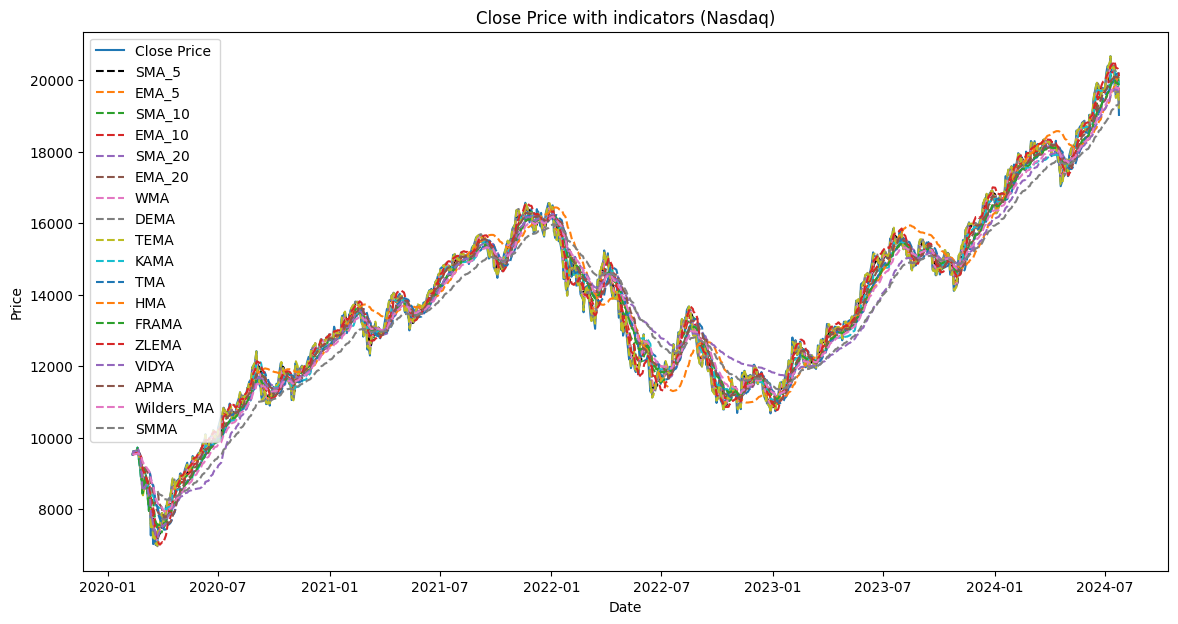

In [52]:


plt.figure(figsize=(14, 7))
plt.plot(dataset['Date'], dataset['Close'], label='Close Price')
plt.plot(dataset['Date'], dataset['SMA_5'],
         label='SMA_5', linestyle='--', color='black')
plt.plot(dataset['Date'], dataset['EMA_5'], label='EMA_5', linestyle='--')
plt.plot(dataset['Date'], dataset['SMA_10'], label='SMA_10', linestyle='--')
plt.plot(dataset['Date'], dataset['EMA_10'], label='EMA_10', linestyle='--')
plt.plot(dataset['Date'], dataset['SMA_20'], label='SMA_20', linestyle='--')
plt.plot(dataset['Date'], dataset['EMA_20'], label='EMA_20', linestyle='--')
plt.plot(dataset['Date'], dataset['WMA'], label='WMA', linestyle='--')
plt.plot(dataset['Date'], dataset['DEMA'], label='DEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TEMA'], label='TEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['KAMA'], label='KAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TMA'], label='TMA', linestyle='--')
plt.plot(dataset['Date'], dataset['HMA'], label='HMA', linestyle='--')
plt.plot(dataset['Date'], dataset['FRAMA'], label='FRAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['ZLEMA'], label='ZLEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['VIDYA'], label='VIDYA', linestyle='--')
plt.plot(dataset['Date'], dataset['APMA'], label='APMA', linestyle='--')
plt.plot(dataset['Date'], dataset['Wilders_MA'],
         label='Wilders_MA', linestyle='--')
plt.plot(dataset['Date'], dataset['SMMA'], label='SMMA', linestyle='--')
plt.title('Close Price with indicators (Nasdaq)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
print(dataset['Close'])

0        9517.860352
1        9613.200195
2        9595.700195
3        9623.580078
4        9629.799805
            ...     
1063    19799.140625
1064    19705.089844
1065    19522.619141
1066    19822.869141
1067    19754.339844
Name: Close, Length: 1068, dtype: float64


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


# Calculate Root Mean Squared Error
# rmse_sma = sqrt(mean_squared_error(
#     dataset['Close'][-20:], dataset['SMA'][-20:]))
# rmse_ema = sqrt(mean_squared_error(dataset['Close'], dataset['EMA']))
# rmse_wma = sqrt(mean_squared_error(
#     dataset['Close'][-20:], dataset['WMA'][-20:]))
# rmse_dema = sqrt(mean_squared_error(dataset['Close'], dataset['DEMA']))
# rmse_tema = sqrt(mean_squared_error(dataset['Close'], dataset['TEMA']))


n = 0
# remove VAMA
list_type = ['SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'WMA', 'DEMA', 'TEMA', 'KAMA',
             'TMA', 'HMA', 'FRAMA', 'ZLEMA', 'VIDYA', 'APMA', 'Wilders_MA', 'SMMA']
rmse_values = []

while (n <= len(list_type)-1):
    rmse = sqrt(mean_squared_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:]))

    print(n+1, ". RMSE ", list_type[n], " =", rmse)
    rmse_values.append((list_type[n], rmse))
    n += 1

rmse_values.sort(key=lambda x: x[1])
print("****************************************")
print("top 10 RMSE values:")
for item in rmse_values[:10]:
    print(f"RMSE {item[0]} = {item[1]}")
print("****************************************")
n = 0
mae_values = []
while (n <= len(list_type)-1):
    mae = mean_absolute_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:])

    print(n+1, ". MAE ", list_type[n], " =", mae)
    mae_values.append((list_type[n], mae))
    n += 1

mae_values.sort(key=lambda x: x[1])
print("****************************************")
print("top 10 MAE values:")
for item in mae_values[:10]:
    print(f"MAE {item[0]} = {item[1]}")

print("****************************************")
print("Comparison between RMSE and MAE:")
for i in range(10):
    rmse_item = rmse_values[i]
    mae_item = mae_values[i]
    print(f"{i+1}. {rmse_item[0]
                    } -> RMSE = {rmse_item[1]}, MAE = {mae_item[1]}")

1 . RMSE  SMA_5  = 246.24147693744152
2 . RMSE  EMA_5  = 198.29754623783197
3 . RMSE  SMA_10  = 366.6859159755454
4 . RMSE  EMA_10  = 298.04705486039444
5 . RMSE  SMA_20  = 496.2245959378205
6 . RMSE  EMA_20  = 477.71378169922565
7 . RMSE  WMA  = 183.3821133648512
8 . RMSE  DEMA  = 120.10658871719878
9 . RMSE  TEMA  = 82.77002287109559
10 . RMSE  KAMA  = 357.8631043084738
11 . RMSE  TMA  = 493.4514368015611
12 . RMSE  HMA  = 702.0167421599203
13 . RMSE  FRAMA  = 458.67966943536396
14 . RMSE  ZLEMA  = 373.8959288987939
15 . RMSE  VIDYA  = 680.9630238631942
16 . RMSE  APMA  = 375.6810213221416
17 . RMSE  Wilders_MA  = 611.5129369174792
18 . RMSE  SMMA  = 1069.0324872571491
****************************************
top 10 RMSE values:
RMSE TEMA = 82.77002287109559
RMSE DEMA = 120.10658871719878
RMSE WMA = 183.3821133648512
RMSE EMA_5 = 198.29754623783197
RMSE SMA_5 = 246.24147693744152
RMSE EMA_10 = 298.04705486039444
RMSE KAMA = 357.8631043084738
RMSE SMA_10 = 366.6859159755454
RMSE ZLEMA

In [9]:
# clear data
# rmse_values.clear()
# mae_values.clear()

SegRNN Model 

In [10]:
# import torch
# import torch.nn as nn
# import math


# class Model(nn.Module):
#     def __init__(self, configs):
#         super(Model, self).__init__()

#         # remove this, the performance will be bad
#         self.lucky = nn.Embedding(configs.enc_in, configs.d_model // 2)

#         self.seq_len = configs.seq_len
#         self.pred_len = configs.pred_len
#         self.enc_in = configs.enc_in
#         self.patch_len = configs.patch_len
#         self.d_model = configs.d_model

#         self.linear_patch = nn.Linear(self.patch_len, self.d_model)
#         self.relu = nn.ReLU()

#         self.gru = nn.GRU(
#             input_size=self.d_model,
#             hidden_size=self.d_model,
#             num_layers=1,
#             bias=True,
#             batch_first=True,
#         )

#         self.pos_emb = nn.Parameter(torch.randn(
#             self.pred_len // self.patch_len, self.d_model // 2))
#         self.channel_emb = nn.Parameter(
#             torch.randn(self.enc_in, self.d_model // 2))

#         self.dropout = nn.Dropout(configs.dropout)
#         self.linear_patch_re = nn.Linear(self.d_model, self.patch_len)

#     def forward(self, x, x_mark, y_true, y_mark):
#         seq_last = x[:, -1:, :].detach()
#         x = x - seq_last

#         B, L, C = x.shape
#         N = self.seq_len // self.patch_len
#         M = self.pred_len // self.patch_len
#         W = self.patch_len
#         d = self.d_model

#         # B, L, C -> B, C, L -> B * C, N, W
#         xw = x.permute(0, 2, 1).reshape(B * C, N, -1)
#         xd = self.linear_patch(xw)  # B * C, N, W -> B * C, N, d
#         enc_in = self.relu(xd)

#         # 1, B * C, d -> 1, B * C, M * d -> 1, B * C * M, d
#         enc_out = self.gru(enc_in)[1].repeat(1, 1, M).view(1, -1, self.d_model)

#         dec_in = torch.cat([
#             # M, d//2 -> 1, M, d//2 -> B * C, M, d//2
#             self.pos_emb.unsqueeze(0).repeat(B*C, 1, 1),
#             # C, d//2 -> C, 1, d//2 -> B * C, M, d//2
#             self.channel_emb.unsqueeze(1).repeat(B, M, 1)
#             # B * C, M, d -> B * C * M, d -> B * C * M, 1, d
#         ], dim=-1).flatten(0, 1).unsqueeze(1)

#         dec_out = self.gru(dec_in, enc_out)[0]  # B * C * M, 1, d

#         yd = self.dropout(dec_out)
#         yw = self.linear_patch_re(yd)  # B * C * M, 1, d -> B * C * M, 1, W
#         y = yw.reshape(B, C, -1).permute(0, 2, 1)  # B, C, H

#         y = y + seq_last

#         return y

Main Transformers model

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from keras import layers
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import time
import timeit
from datetime import datetime
from math import sqrt

In [25]:

class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        # data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(
                self.datainput.values.reshape(-1, 1))
            return data
        else:
            data = self.datainput
            return data

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        print("data shape:", data.shape)
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        print("train shape:", train.shape, "test shape:", test.shape)
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer: tf.keras.Model, x_train, y_train, X_val, y_val, display_loss=False):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True)]
    start = time.time()
    # hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    hist = transformer.fit(x_train, y_train, validation_data=(X_val, y_val),
                           batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    print("time used", time.time() - start)
    history_df = pd.DataFrame(hist.history)

    if display_loss:
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        # Display minimum validation loss
        min_val_loss = history_df['val_loss'].min()
        print("Minimum validation loss: {:.4f}".format(min_val_loss))
        # Plot mae
        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        # Display minimum validation mae and mape
        min_val_mae = history_df['val_mae'].min()
        min_val_mape = history_df['val_mape'].min()
        print("Minimum validation MAE: {:.4f}".format(min_val_mae))
        print("Minimum validation MAPE: {:.4f}".format(min_val_mape))

    return hist

# **********************


class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """

    def __init__(self, model, train, test, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        predictions = np.array(predictions)
        # if self.normalize_bool:
        # Inverse transform to get back to original scale
        #    predictions = self.scaler.inverse_transform(
        #        predictions.reshape(-1, 1)).reshape(predictions.shape)
        return predictions


class Evaluate:

    def __init__(self, actual, predictions, normalize_bool, scaler) -> None:
        print(
            f"Initial lengths - actual: {len(actual)}, predictions: {len(predictions)}")
        if normalize_bool == True:
            actual = scaler.inverse_transform(
                actual.reshape(-1, 1)).reshape(actual.shape)
            predictions = scaler.inverse_transform(
                predictions.reshape(-1, 1)).reshape(predictions.shape)
        self.actual = actual
        self.predictions = predictions
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_rmse(self):
        return root_mean_squared_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_mae(self):
        return mean_absolute_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_r2(self):
        return r2_score(self.actual.flatten(), self.predictions.flatten())


def plot_results(train, test, preds, df, normalize_bool, scaler, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool == True:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

Comparison between RMSE and MAE:
1. TEMA -> RMSE = 82.77002287109559, MAE = 62.72709258243849
2. DEMA -> RMSE = 120.10658871719878, MAE = 91.31564249421808
3. WMA -> RMSE = 183.3821133648512, MAE = 144.49500651041672
4. EMA_5 -> RMSE = 198.29754623783197, MAE = 153.5413996948202
5. SMA_5 -> RMSE = 246.24147693744152, MAE = 187.78255859375003
6. EMA_10 -> RMSE = 298.04705486039444, MAE = 248.38187324143365
7. KAMA -> RMSE = 357.8631043084738, MAE = 288.8012514772814
8. SMA_10 -> RMSE = 366.6859159755454, MAE = 289.8100097656252
9. ZLEMA -> RMSE = 373.8959288987939, MAE = 298.667564304378
10. APMA -> RMSE = 375.6810213221416, MAE = 326.82132329058385

In [3]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset['Close'] = dataset['Close']


def kama_indicator(price, period=10, period_fast=2, period_slow=30):
    price = pd.Series(price)
    # Efficiency Ratio
    change = abs(price-price.shift(period))
    volatility = (abs(price-price.shift())).rolling(period).sum()
    er = change/volatility

    # Smoothing Constant
    sc_fatest = 2/(period_fast + 1)
    sc_slowest = 2/(period_slow + 1)
    sc = (er * (sc_fatest - sc_slowest) + sc_slowest)**2

    # KAMA
    kama = np.zeros_like(price)
    kama[period-1] = price[period-1]

    for i in range(period, len(price)):
        kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])

    kama[kama == 0] = np.nan

    return pd.Series(kama)


def calculate_TEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema


def calculate_DEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


def calculate_ZLEMA(prices, period):
    prices = pd.Series(prices)  # Ensure prices is a pandas Series
    lag = period // 2
    adjusted_prices = [
        2 * prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))
    ]
    adjusted_prices = pd.Series(adjusted_prices)
    zlema = adjusted_prices.ewm(span=period, adjust=False).mean()
    return pd.Series(zlema)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return pd.Series(moving_averages)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

[*********************100%%**********************]  1 of 1 completed


In [4]:
list_type_used = ['TEMA', 'DEMA', 'WMA', 'EMA_5',
                  'SMA_5', 'EMA_10', 'KAMA', 'SMA_10', 'ZLEMA', 'APMA']
# ticker = 'NDX'
ticker = 'aapl'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]


def apply_moving_average(dataset, ma_type):
    ma_functions = {
        0: lambda x: calculate_TEMA(x['Close'], 5),  # TEMA
        1: lambda x: calculate_DEMA(x['Close'], 5),  # DEMA
        2: lambda x: weighted_moving_average(x['Close'], 5),  # WMA
        3: lambda x: x['Close'].ewm(span=5, adjust=False).mean(),  # EMA_5
        4: lambda x: x['Close'].rolling(window=5).mean(),  # SMA_5
        5: lambda x: x['Close'].ewm(span=10, adjust=False).mean(),  # EMA_10
        6: lambda x: kama_indicator(x['Close']),  # KAMA
        7: lambda x: x['Close'].rolling(window=10).mean(),  # SMA_10
        8: lambda x: calculate_ZLEMA(x['Close'].tolist(), 28),  # ZLEMA
        9: lambda x: adaptive_period_moving_average(x['Close'].values)  # APMA
    }
    if ma_type not in ma_functions:
        raise ValueError(f"Invalid ma_type: {
                         ma_type}. Must be between 0 and 9.")
    return ma_functions[ma_type](dataset)


for j in range(len(list_type_used)):
    dataset = yf.download(ticker, start='1990-01-01',
                          end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
    dataset = dataset[['Close']]
    dataset_ma = apply_moving_average(dataset, j)
    dataset_ma.dropna(inplace=True)
    print(f"MA type: {list_type_used[j]}")
    print(dataset_ma)
    print("******************")
    if j >= 9:
        print("*Done*")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


MA type: TEMA
Date
1990-01-02      0.332589
1990-01-03      0.334160
1990-01-04      0.335607
1990-01-05      0.336944
1990-01-08      0.338980
                 ...    
2024-07-19    223.926664
2024-07-22    223.036118
2024-07-23    223.642812
2024-07-24    219.566852
2024-07-25    217.258814
Name: Close, Length: 8707, dtype: float64
******************
MA type: DEMA
Date
1990-01-02      0.332589
1990-01-03      0.333829
1990-01-04      0.335111
1990-01-05      0.336393
1990-01-08      0.338276
                 ...    
2024-07-19    225.844556
2024-07-22    224.492066
2024-07-23    224.415168
2024-07-24    220.852638
2024-07-25    218.429004
Name: Close, Length: 8707, dtype: float64
******************
MA type: WMA
Date
1990-01-08      0.336979
1990-01-09      0.336980
1990-01-10      0.331920
1990-01-11      0.323289
1990-01-12      0.316518
                 ...    
2024-07-19    227.263332
2024-07-22    225.477335
2024-07-23    224.737332
2024-07-24    222.494663
2024-07-25    220.5913

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])


MA type: SMA_5
Date
1990-01-08      0.335938
1990-01-09      0.336607
1990-01-10      0.333929
1990-01-11      0.328349
1990-01-12      0.322545
                 ...    
2024-07-19    229.317999
2024-07-22    227.230002
2024-07-23    225.267999
2024-07-24    223.199997
2024-07-25    221.862000
Name: Close, Length: 8703, dtype: float64
******************
MA type: EMA_10
Date
1990-01-02      0.332589
1990-01-03      0.332995
1990-01-04      0.333530
1990-01-05      0.334171
1990-01-08      0.335101
                 ...    
2024-07-19    226.930399
2024-07-22    226.390328
2024-07-23    226.139358
2024-07-24    224.757655
2024-07-25    223.436264
Name: Close, Length: 8707, dtype: float64
******************
MA type: KAMA
9         0.305804
10        0.306463
11        0.304450
12        0.300594
13        0.301059
           ...    
8702    228.404521
8703    228.311293
8704    228.246236
8705    227.108873
8706    226.300931
Length: 8698, dtype: float64
******************


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

MA type: SMA_10
Date
1990-01-15      0.325893
1990-01-16      0.323773
1990-01-17      0.319978
1990-01-18      0.315291
1990-01-19      0.312166
                 ...    
2024-07-19    229.417999
2024-07-22    229.031999
2024-07-23    228.664999
2024-07-24    227.220999
2024-07-25    226.212999
Name: Close, Length: 8698, dtype: float64
******************
MA type: ZLEMA
0         0.332589
1         0.332897
2         0.333338
3         0.333902
4         0.334735
           ...    
8702    234.413601
8703    234.189905
8704    233.883704
8705    232.617930
8706    230.964281
Length: 8707, dtype: float64
******************
MA type: APMA
29        0.308116
30        0.307119
31        0.304770
32        0.302768
33        0.302500
           ...    
8702    220.620417
8703    221.609091
8704    222.305910
8705    222.142174
8706    223.233182
Length: 8678, dtype: float64
******************
*Done*


[*********************100%%**********************]  1 of 1 completed


(1393, 5, 1)
(348, 5, 1)
[[[ 0.33415966]
  [ 0.33560704]
  [ 0.33694379]
  [ 0.33897993]
  [ 0.33735876]]

 [[ 0.33560704]
  [ 0.33694379]
  [ 0.33897993]
  [ 0.33735876]
  [ 0.32629959]]

 [[ 0.33694379]
  [ 0.33897993]
  [ 0.33735876]
  [ 0.32629959]
  [ 0.3121545 ]]

 ...

 [[39.66326032]
  [40.05221243]
  [40.34243262]
  [39.40658722]
  [39.34650936]]

 [[40.05221243]
  [40.34243262]
  [39.40658722]
  [39.34650936]
  [39.73931145]]

 [[40.34243262]
  [39.40658722]
  [39.34650936]
  [39.73931145]
  [40.21726481]]] [[ 0.32629959  0.3121545   0.30656222  0.30343789  0.30686109]
 [ 0.3121545   0.30656222  0.30343789  0.30686109  0.2988143 ]
 [ 0.30656222  0.30343789  0.30686109  0.2988143   0.29033449]
 ...
 [39.73931145 40.21726481 40.29450445 39.75949048 39.4508678 ]
 [40.21726481 40.29450445 39.75949048 39.4508678  39.27551011]
 [40.29450445 39.75949048 39.4508678  39.27551011 39.67045085]]
[[[ 39.86097281]
  [ 39.94452537]
  [ 40.25874317]
  [ 40.6383152 ]
  [ 40.85955463]]

 [[ 39

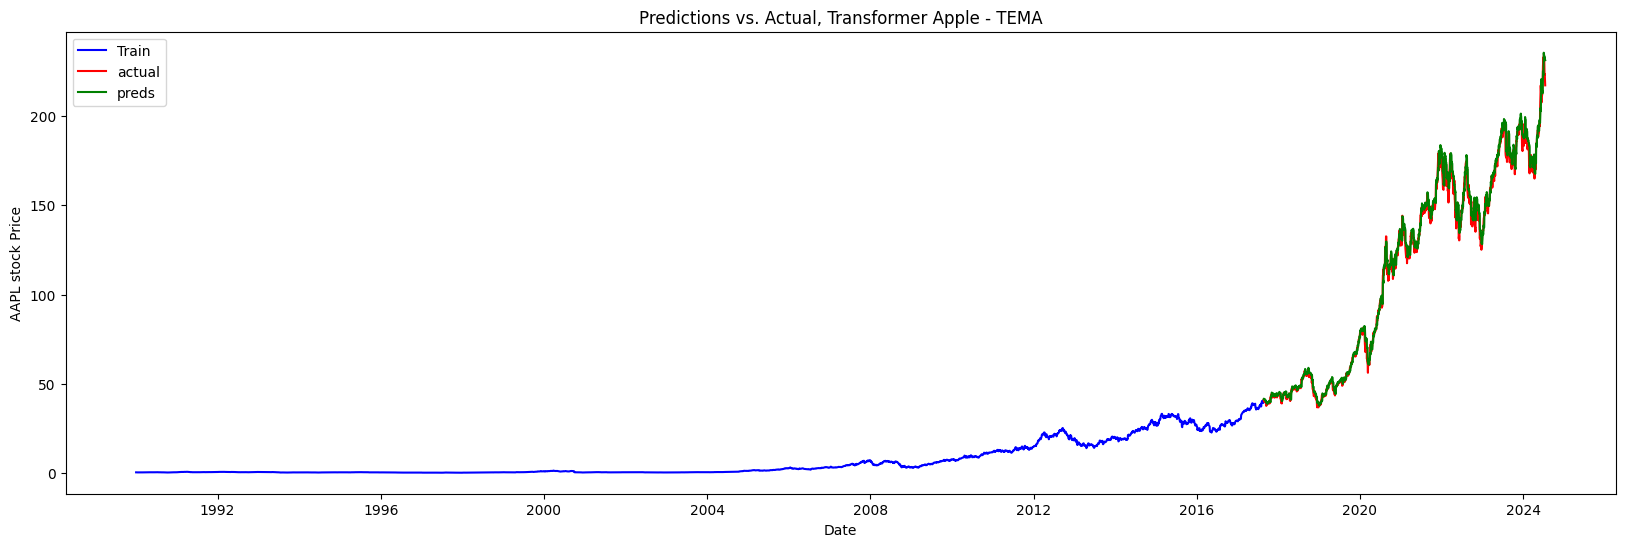

MAPE for TEMA: 0.025754603577797117
RMSE for TEMA: 4.173933876887352
MAE for TEMA: 2.900641799657498
R-squared for TEMA: 0.9942561494630388
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33382899]
  [ 0.33511089]
  [ 0.33639253]
  [ 0.33827563]
  [ 0.33736484]]

 [[ 0.33511089]
  [ 0.33639253]
  [ 0.33827563]
  [ 0.33736484]
  [ 0.32874095]]

 [[ 0.33639253]
  [ 0.33827563]
  [ 0.33736484]
  [ 0.32874095]
  [ 0.31665511]]

 ...

 [[39.4997382 ]
  [39.9047963 ]
  [40.2337331 ]
  [39.5861804 ]
  [39.51435774]]

 [[39.9047963 ]
  [40.2337331 ]
  [39.5861804 ]
  [39.51435774]
  [39.79556481]]

 [[40.2337331 ]
  [39.5861804 ]
  [39.51435774]
  [39.79556481]
  [40.1821498 ]]] [[ 0.32874095  0.31665511  0.31032595  0.30601856  0.30718031]
 [ 0.31665511  0.31032595  0.30601856  0.30718031  0.30010317]
 [ 0.31032595  0.30601856  0.30718031  0.30010317  0.29225909]
 ...
 [39.79556481 40.1821498  40.28789205 39.90012325 39.62943446]
 [40.1821498  40.28789205 39.90012325 39.62943446 39.440581  ]
 [40.28789205 39.

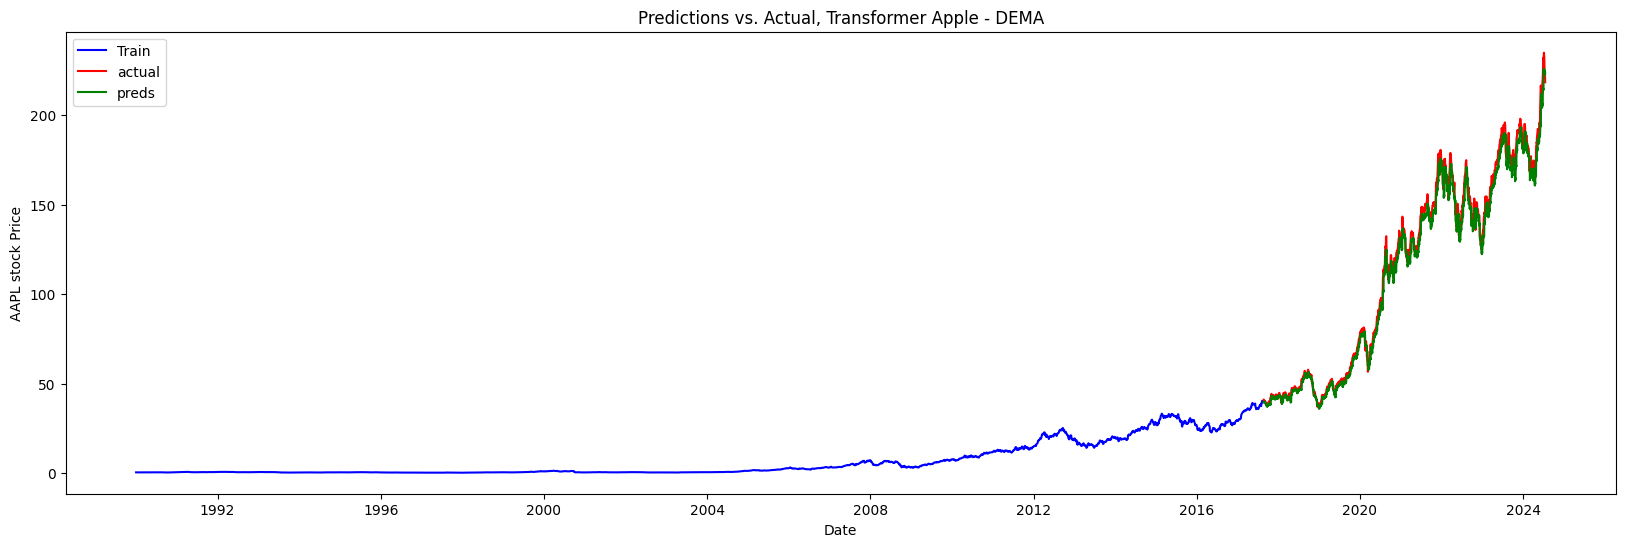

MAPE for DEMA: 0.033043667282504775
RMSE for DEMA: 4.8975835862320505
MAE for DEMA: 3.723746687572814
R-squared for DEMA: 0.9920946553789832
(1392, 5, 1)
(348, 5, 1)
[[[ 0.33192008]
  [ 0.32328907]
  [ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]]

 [[ 0.32328907]
  [ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]
  [ 0.30476207]]

 [[ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]
  [ 0.30476207]
  [ 0.2991074 ]]

 ...

 [[39.17750015]
  [39.55150019]
  [39.8399999 ]
  [39.58483378]
  [39.51383336]]

 [[39.55150019]
  [39.8399999 ]
  [39.58483378]
  [39.51383336]
  [39.62216721]]

 [[39.8399999 ]
  [39.58483378]
  [39.51383336]
  [39.62216721]
  [39.85900091]]] [[ 0.30476207  0.2991074   0.30029794  0.29866094  0.2991072 ]
 [ 0.2991074   0.30029794  0.29866094  0.2991072   0.30096713]
 [ 0.30029794  0.29866094  0.2991072   0.30096713  0.302753  ]
 ...
 [39.62216721 39.85900091 40.01633377 39.91800028 39.74733353]
 [39.85900091 40.01633377 39.91800028 39.74733353 39.55216726]
 [40.01633377 39

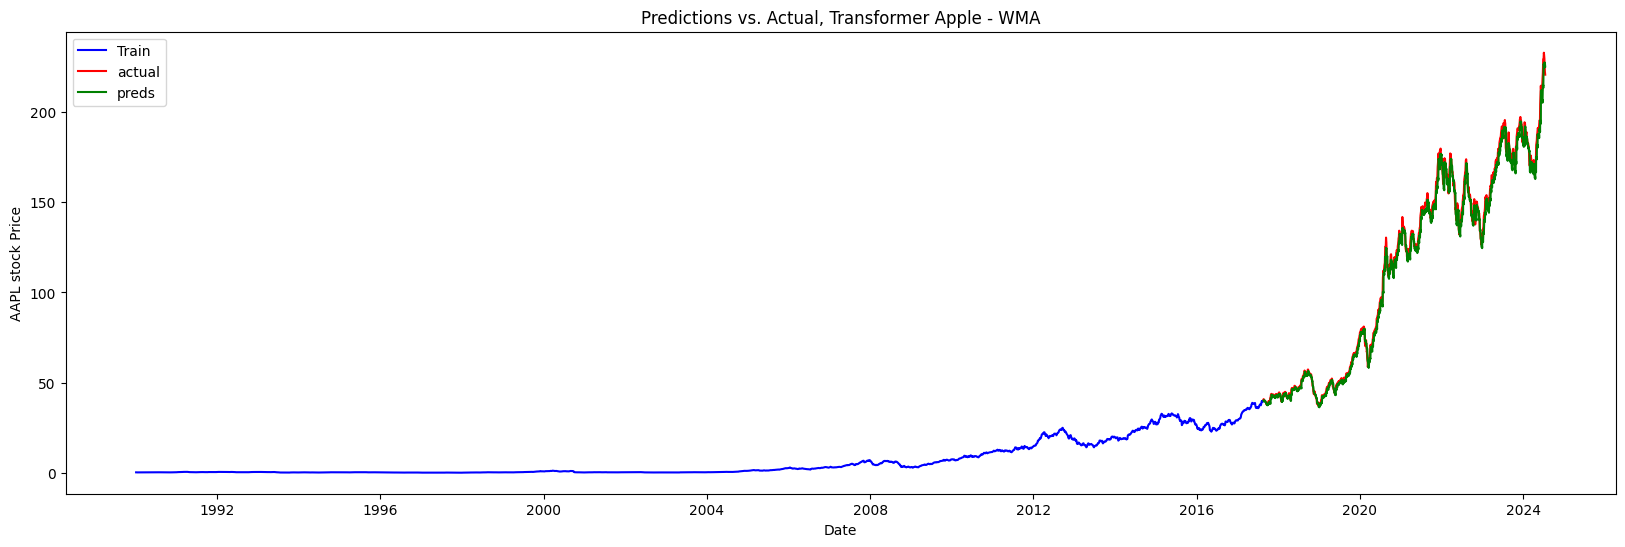

MAPE for WMA: 0.02452184222204327
RMSE for WMA: 3.808410736800631
MAE for WMA: 2.752507638602421
R-squared for WMA: 0.9952045967710443
(1393, 5, 1)
(348, 5, 1)
[[[ 0.333333  ]
  [ 0.33420133]
  [ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]]

 [[ 0.33420133]
  [ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]
  [ 0.33136485]]

 [[ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]
  [ 0.33136485]
  [ 0.32358857]]

 ...

 [[38.97763242]
  [39.32508843]
  [39.63839208]
  [39.36892867]
  [39.36928542]]

 [[39.32508843]
  [39.63839208]
  [39.36892867]
  [39.36928542]
  [39.56702412]]

 [[39.63839208]
  [39.36892867]
  [39.36928542]
  [39.56702412]
  [39.84468326]]] [[ 0.33136485  0.32358857  0.31840438  0.31420426  0.31326417]
 [ 0.32358857  0.31840438  0.31420426  0.31326417  0.30780111]
 [ 0.31840438  0.31420426  0.31326417  0.30780111  0.30155508]
 ...
 [39.56702412 39.84468326 39.97562192 39.80541466 39.66194311]
 [39.84468326 39.97562192 39.80541466 39.66194311 39.5421293 ]
 [39.97562192 39.80541

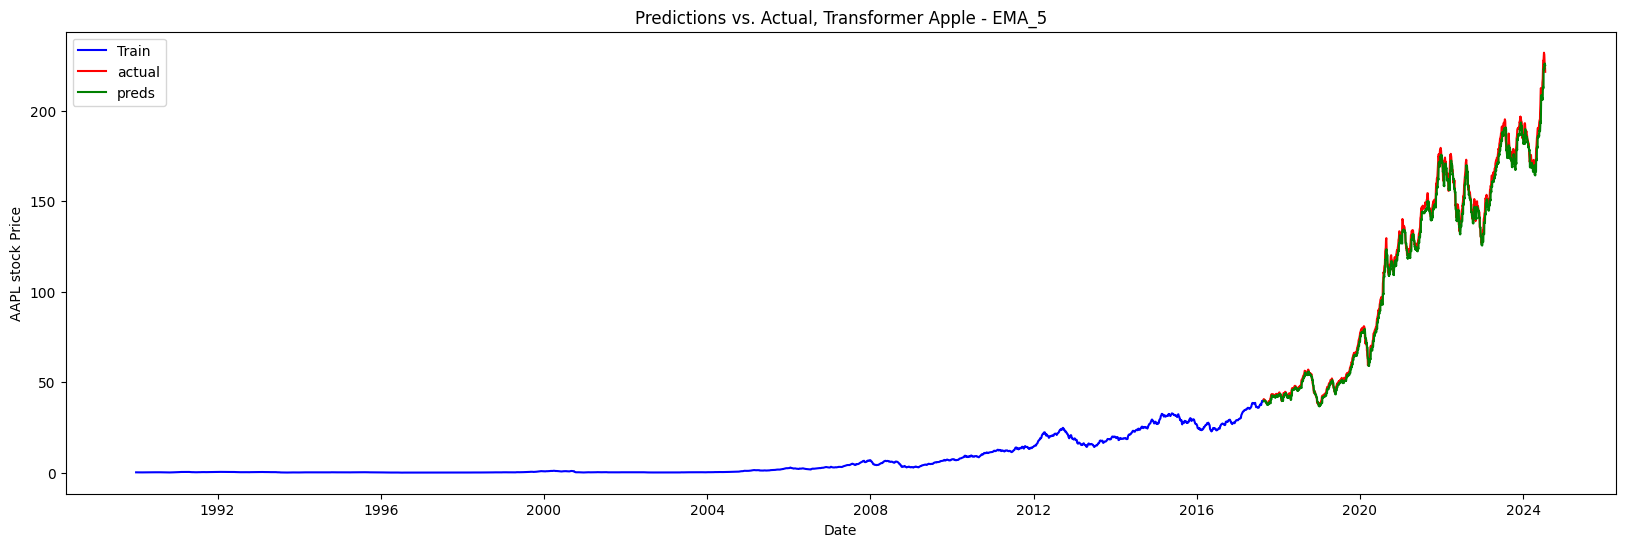

MAPE for EMA_5: 0.026017568276617185
RMSE for EMA_5: 3.840642054138089
MAE for EMA_5: 2.9047596204106156
R-squared for EMA_5: 0.99511473019531
(1392, 5, 1)
(348, 5, 1)
[[[ 0.33392901]
  [ 0.32834861]
  [ 0.322545  ]
  [ 0.31584861]
  [ 0.3109378 ]]

 [[ 0.32834861]
  [ 0.322545  ]
  [ 0.31584861]
  [ 0.3109378 ]
  [ 0.306027  ]]

 [[ 0.322545  ]
  [ 0.31584861]
  [ 0.3109378 ]
  [ 0.306027  ]
  [ 0.3022324 ]]

 ...

 [[38.89800034]
  [39.39950027]
  [39.59550018]
  [39.58300018]
  [39.6375    ]]

 [[39.39950027]
  [39.59550018]
  [39.58300018]
  [39.6375    ]
  [39.68950043]]

 [[39.59550018]
  [39.58300018]
  [39.6375    ]
  [39.68950043]
  [39.76550064]]] [[ 0.306027    0.3022324   0.30178601  0.3000002   0.2979912 ]
 [ 0.3022324   0.30178601  0.3000002   0.2979912   0.2993304 ]
 [ 0.30178601  0.3000002   0.2979912   0.2993304   0.3024554 ]
 ...
 [39.68950043 39.76550064 39.76000061 39.88700027 39.88800049]
 [39.76550064 39.76000061 39.88700027 39.88800049 39.75600052]
 [39.76000061 

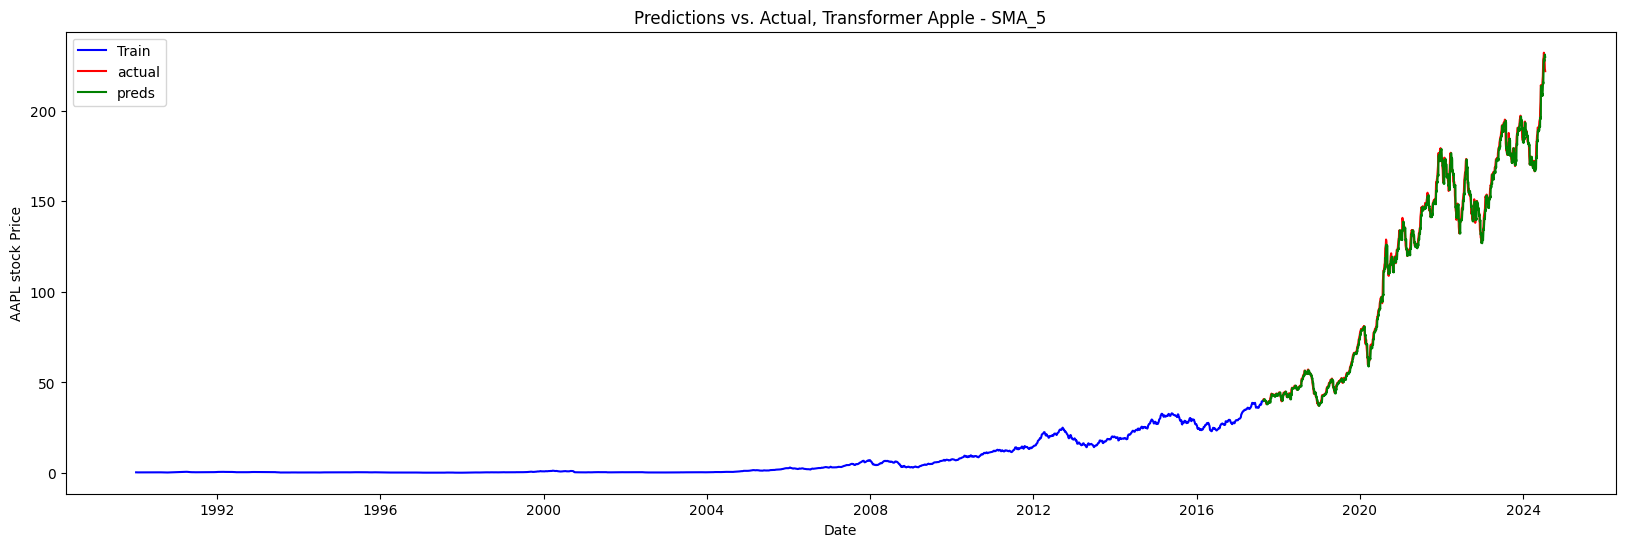

MAPE for SMA_5: 0.018852985752514772
RMSE for SMA_5: 3.0928656684391798
MAE for SMA_5: 2.111164267967487
R-squared for SMA_5: 0.9968341893101225
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33299482]
  [ 0.33352994]
  [ 0.33417068]
  [ 0.33510074]
  [ 0.33525297]]

 [[ 0.33352994]
  [ 0.33417068]
  [ 0.33510074]
  [ 0.33525297]
  [ 0.33273952]]

 [[ 0.33417068]
  [ 0.33510074]
  [ 0.33525297]
  [ 0.33273952]
  [ 0.32824797]]

 ...

 [[38.49507617]
  [38.77233513]
  [39.04372863]
  [39.00486921]
  [39.07125643]]

 [[38.77233513]
  [39.04372863]
  [39.00486921]
  [39.07125643]
  [39.233301  ]]

 [[39.04372863]
  [39.00486921]
  [39.07125643]
  [39.233301  ]
  [39.44542837]]] [[ 0.33273952  0.32824797  0.32457307  0.32116051  0.31938296]
 [ 0.32824797  0.32457307  0.32116051  0.31938296  0.31529061]
 [ 0.32457307  0.32116051  0.31938296  0.31529061  0.31052195]
 ...
 [39.233301   39.44542837 39.58944125 39.5668156  39.53194003]
 [39.44542837 39.58944125 39.5668156  39.53194003 39.49022397]
 [39.5894412

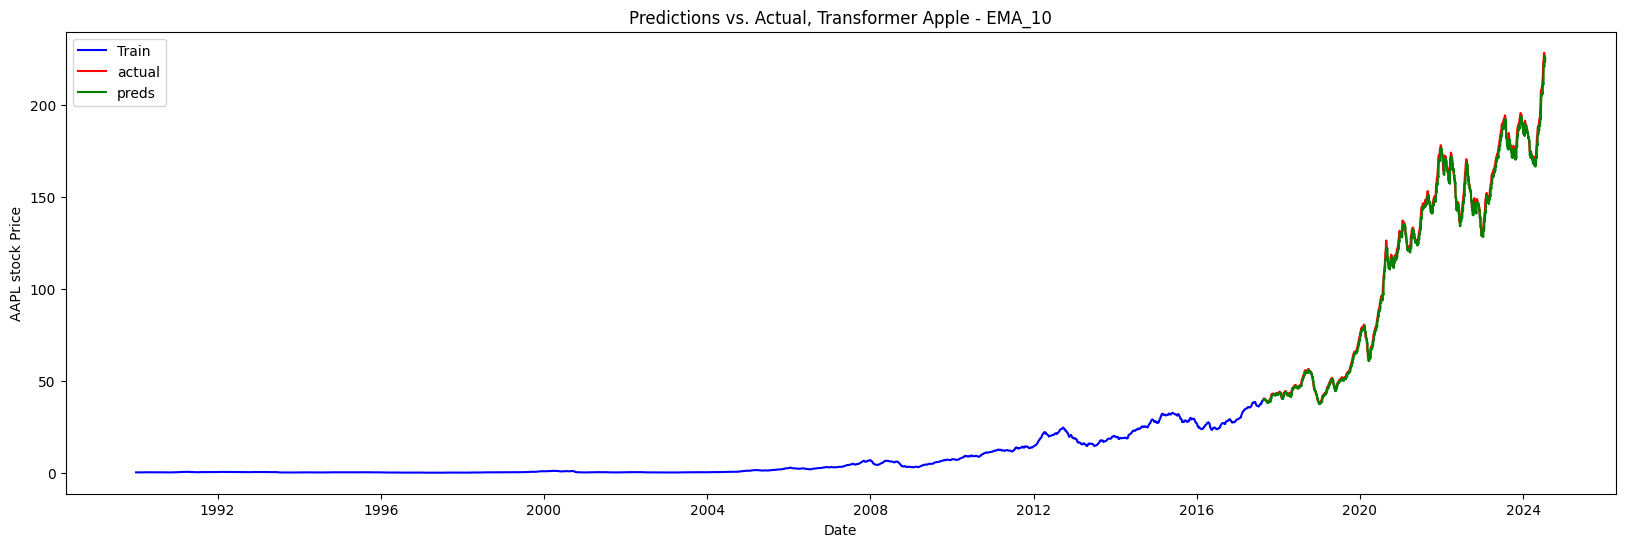

MAPE for EMA_10: 0.018687527708922874
RMSE for EMA_10: 2.78001439528459
MAE for EMA_10: 2.0593146948815626
R-squared for EMA_10: 0.9974264674410835
(1391, 5, 1)
(348, 5, 1)
[[[ 0.30059421]
  [ 0.301059  ]
  [ 0.30052314]
  [ 0.30059696]
  [ 0.30072342]]

 [[ 0.301059  ]
  [ 0.30052314]
  [ 0.30059696]
  [ 0.30072342]
  [ 0.30076012]]

 [[ 0.30052314]
  [ 0.30059696]
  [ 0.30072342]
  [ 0.30076012]
  [ 0.30046349]]

 ...

 [[38.41907805]
  [38.57546512]
  [38.58454965]
  [38.63911422]
  [38.77859879]]

 [[38.57546512]
  [38.58454965]
  [38.63911422]
  [38.77859879]
  [38.95546148]]

 [[38.58454965]
  [38.63911422]
  [38.77859879]
  [38.95546148]
  [38.99736752]]] [[ 0.30076012  0.30046349  0.30039969  0.30044836  0.30049857]
 [ 0.30046349  0.30039969  0.30044836  0.30049857  0.30049004]
 [ 0.30039969  0.30044836  0.30049857  0.30049004  0.30051215]
 ...
 [38.95546148 38.99736752 39.00519852 39.00865404 39.01261809]
 [38.99736752 39.00519852 39.00865404 39.01261809 39.01766418]
 [39.0051

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 34.1892 - mae: 2.3584 - mape: 98.1949 - val_loss: 12.6489 - val_mae: 2.4247 - val_mape: 2.1627
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8355 - mae: 0.4254 - mape: 9.6422 - val_loss: 12.0827 - val_mae: 2.4298 - val_mape: 2.1893
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7101 - mae: 0.3917 - mape: 9.5392 - val_loss: 9.1348 - val_mae: 2.0315 - val_mape: 1.8276
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5605 - mae: 0.3506 - mape: 10.1846 - val_loss: 12.4776 - val_mae: 2.6118 - val_mape: 2.3288
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5007 - mae: 0.3418 - mape: 11.4592 - val_loss: 13.1439 - val_mae: 2.6001 - val_mape: 2.3186
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4785 - mae: 0.3321 - mape: 10.1888 - val_loss: 8.2197 - val_mae: 1.9037 - val_mape: 1.7081
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4010 - mae: 0.3033 - mape: 9

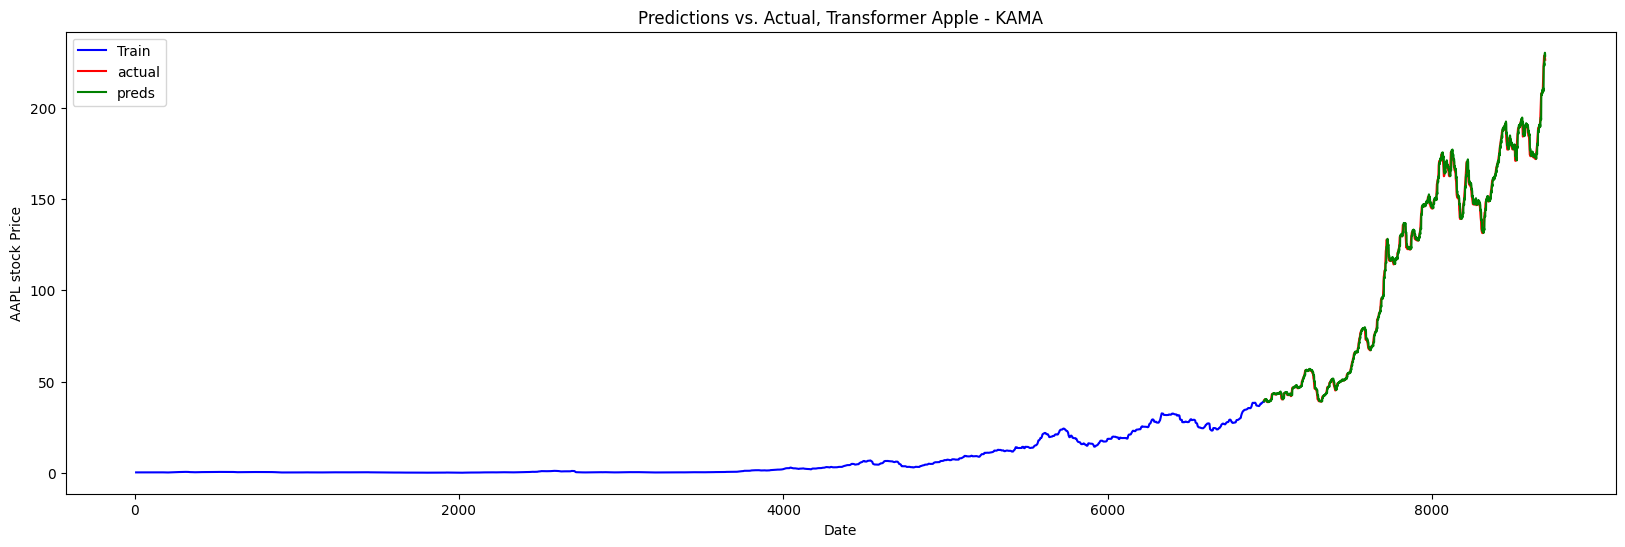

MAPE for KAMA: 0.013948881928584693
RMSE for KAMA: 2.4363273302817996
MAE for KAMA: 1.5546423573714112
R-squared for KAMA: 0.9980188171116641
(1391, 5, 1)
(348, 5, 1)
[[[ 0.3152905 ]
  [ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]]

 [[ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]]

 [[ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]
  [ 0.3007814 ]]

 ...

 [[38.50725021]
  [38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]]

 [[38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]]

 [[38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]
  [39.6777504 ]]] [[ 0.3023439   0.3007814   0.2998885   0.2991072   0.2997768 ]
 [ 0.3007814   0.2998885   0.2991072   0.2997768   0.3008928 ]
 [ 0.2998885   0.2991072   0.2997768   0.3008928   0.3008928 ]
 ...
 [39.58250046 39.6777504  39.73500023 39.76275024 39.72275047]
 [39.6777504  39.73500023 39.76275024 39.72275047 39.7152504 ]
 [39.73500023 3

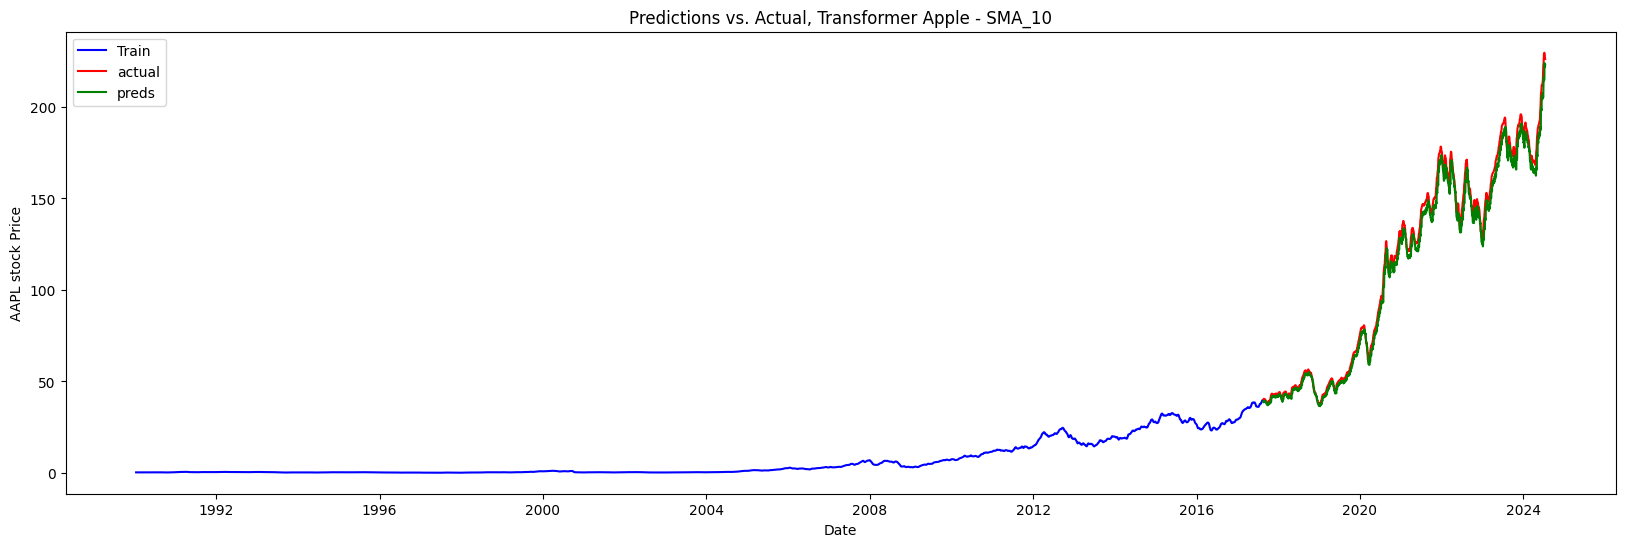

MAPE for SMA_10: 0.03495209364482401
RMSE for SMA_10: 4.840939319938939
MAE for SMA_10: 3.9182851594069907
R-squared for SMA_10: 0.9922071926385896
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33289686]
  [ 0.33333756]
  [ 0.3339018 ]
  [ 0.33473499]
  [ 0.33504892]]

 [[ 0.33333756]
  [ 0.3339018 ]
  [ 0.33473499]
  [ 0.33504892]
  [ 0.33333996]]

 [[ 0.3339018 ]
  [ 0.33473499]
  [ 0.33504892]
  [ 0.33333996]
  [ 0.32990155]]

 ...

 [[38.72202105]
  [38.96774372]
  [39.24203724]
  [39.30069002]
  [39.39840097]]

 [[38.96774372]
  [39.24203724]
  [39.30069002]
  [39.39840097]
  [39.55989067]]

 [[39.24203724]
  [39.30069002]
  [39.39840097]
  [39.55989067]
  [39.75817417]]] [[ 0.33333996  0.32990155  0.32670027  0.32341191  0.32111998]
 [ 0.32990155  0.32670027  0.32341191  0.32111998  0.31698488]
 [ 0.32670027  0.32341191  0.32111998  0.31698488  0.31205744]
 ...
 [39.55989067 39.75817417 39.97036899 40.07965391 40.18226406]
 [39.75817417 39.97036899 40.07965391 40.18226406 40.24503913]
 [39.9703

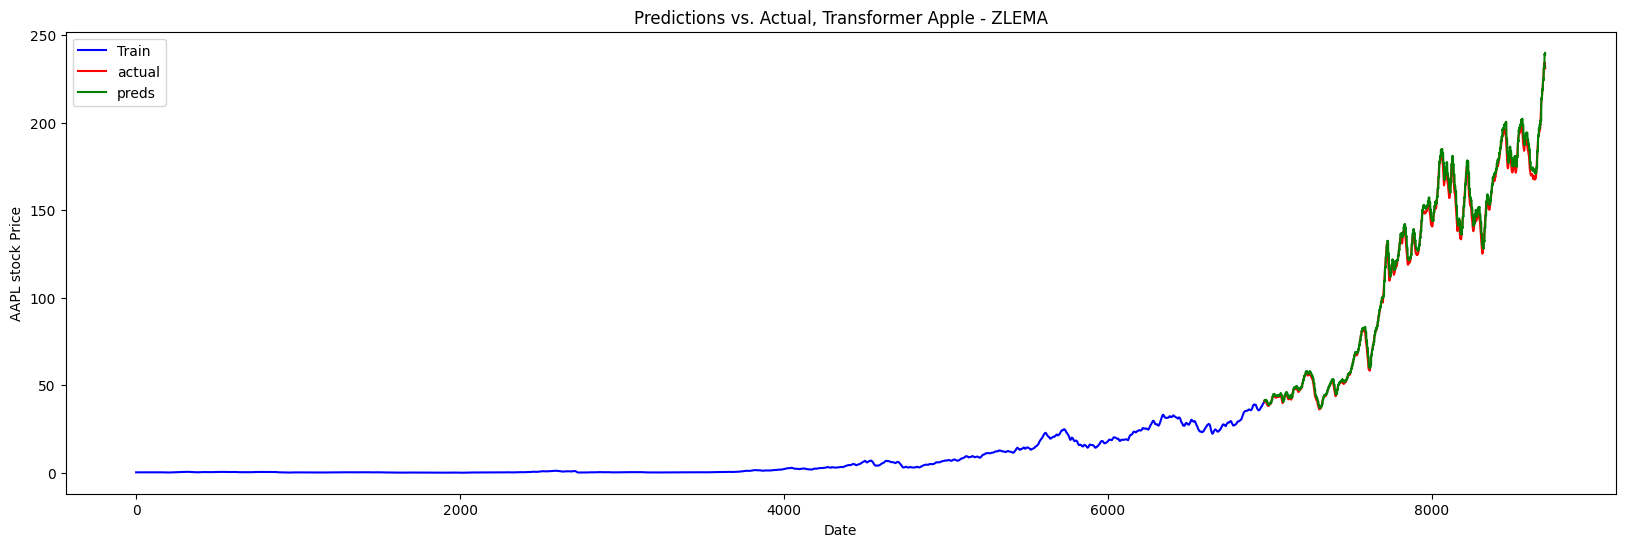

MAPE for ZLEMA: 0.021715705674993712
RMSE for ZLEMA: 3.372374600456752
MAE for ZLEMA: 2.4343063416892163
R-squared for ZLEMA: 0.9962639867162009
(1388, 5, 1)
(347, 5, 1)
[[[ 0.3047703 ]
  [ 0.30276796]
  [ 0.30250008]
  [ 0.3022322 ]
  [ 0.30191968]]

 [[ 0.30276796]
  [ 0.30250008]
  [ 0.3022322 ]
  [ 0.30191968]
  [ 0.30163981]]

 [[ 0.30250008]
  [ 0.3022322 ]
  [ 0.30191968]
  [ 0.30163981]
  [ 0.30214288]]

 ...

 [[38.25677109]
  [38.42197943]
  [38.61576113]
  [38.65114609]
  [38.78663071]]

 [[38.42197943]
  [38.61576113]
  [38.65114609]
  [38.78663071]
  [38.91159127]]

 [[38.61576113]
  [38.65114609]
  [38.78663071]
  [38.91159127]
  [39.01965939]]] [[ 0.30163981  0.30214288  0.30219781  0.30194023  0.30219777]
 [ 0.30214288  0.30219781  0.30194023  0.30219777  0.30232144]
 [ 0.30219781  0.30194023  0.30219777  0.30232144  0.30218748]
 ...
 [38.91159127 39.01965939 39.15333357 39.30162525 39.43112526]
 [39.01965939 39.15333357 39.30162525 39.43112526 39.59037533]
 [39.1533335

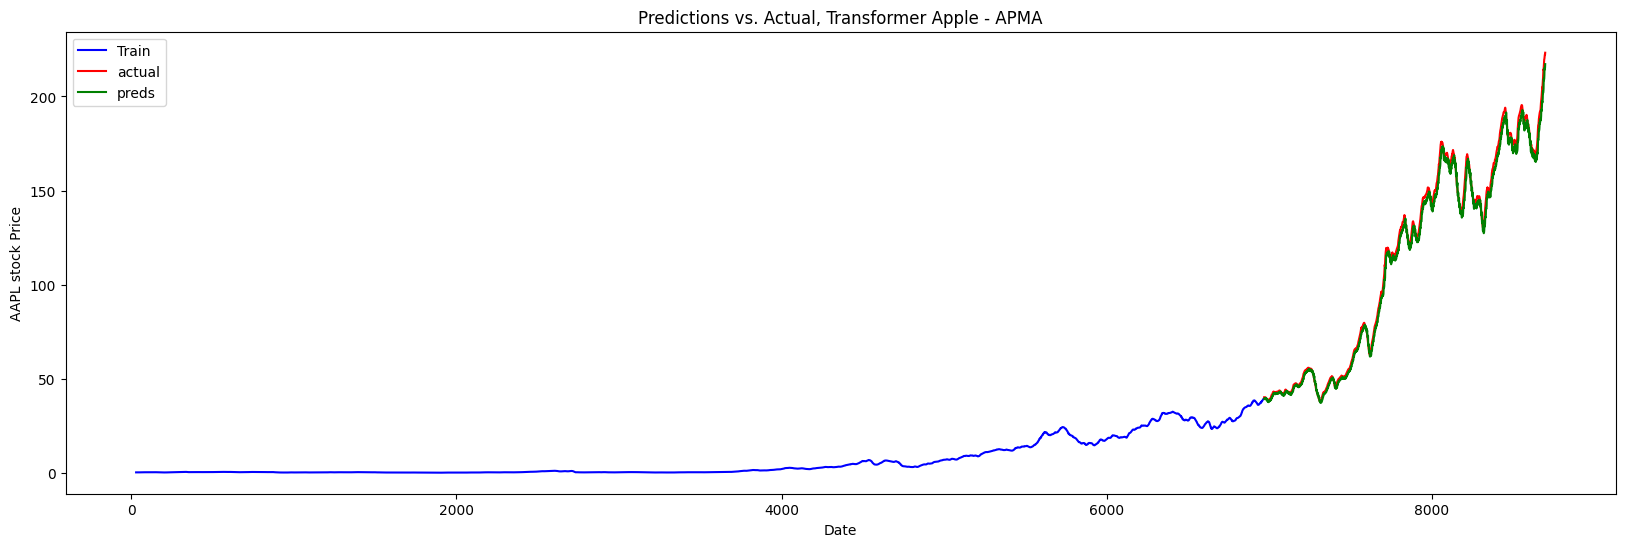

MAPE for APMA: 0.025291073597779778
RMSE for APMA: 3.4746183576341503
MAE for APMA: 2.8228190762745258
R-squared for APMA: 0.9959339379650705


In [5]:

list_type_used = ['TEMA', 'DEMA', 'WMA', 'EMA_5',
                  'SMA_5', 'EMA_10', 'KAMA', 'SMA_10', 'ZLEMA', 'APMA']
# ticker = 'NDX'
ticker = 'aapl'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]


def apply_moving_average(dataset, ma_type):
    ma_functions = {
        0: lambda x: calculate_TEMA(x['Close'], 5),  # TEMA
        1: lambda x: calculate_DEMA(x['Close'], 5),  # DEMA
        2: lambda x: weighted_moving_average(x['Close'], 5),  # WMA
        3: lambda x: x['Close'].ewm(span=5, adjust=False).mean(),  # EMA_5
        4: lambda x: x['Close'].rolling(window=5).mean(),  # SMA_5
        5: lambda x: x['Close'].ewm(span=10, adjust=False).mean(),  # EMA_10
        6: lambda x: kama_indicator(x['Close']),  # KAMA
        7: lambda x: x['Close'].rolling(window=10).mean(),  # SMA_10
        8: lambda x: calculate_ZLEMA(x['Close'].tolist(), 28),  # ZLEMA
        9: lambda x: adaptive_period_moving_average(x['Close'].values)  # APMA
    }
    if ma_type not in ma_functions:
        raise ValueError(f"Invalid ma_type: {
                         ma_type}. Must be between 0 and 9.")
    return ma_functions[ma_type](dataset)


for j in range(len(list_type_used)):
    try:
        dataset_ma = apply_moving_average(dataset, j)
        dataset_ma.dropna(inplace=True)

        normaliza_bool_update = False
        type_normalisation_update = None

        data = ETL(datainput=dataset_ma, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=False)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer Apple - {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")

Normalisation

(1393, 5, 1)
(348, 5, 1)
[[[0.00092882]
  [0.00093499]
  [0.00094069]
  [0.00094936]
  [0.00094245]]

 [[0.00093499]
  [0.00094069]
  [0.00094936]
  [0.00094245]
  [0.00089534]]

 [[0.00094069]
  [0.00094936]
  [0.00094245]
  [0.00089534]
  [0.00083507]]

 ...

 [[0.16849599]
  [0.17015317]
  [0.1713897 ]
  [0.1674024 ]
  [0.16714643]]

 [[0.17015317]
  [0.1713897 ]
  [0.1674024 ]
  [0.16714643]
  [0.16882002]]

 [[0.1713897 ]
  [0.1674024 ]
  [0.16714643]
  [0.16882002]
  [0.1708564 ]]] [[0.00089534 0.00083507 0.00081124 0.00079793 0.00081252]
 [0.00083507 0.00081124 0.00079793 0.00081252 0.00077823]
 [0.00081124 0.00079793 0.00081252 0.00077823 0.0007421 ]
 ...
 [0.16882002 0.1708564  0.17118549 0.16890599 0.16759106]
 [0.1708564  0.17118549 0.16890599 0.16759106 0.16684392]
 [0.17118549 0.16890599 0.16759106 0.16684392 0.16852663]]
[[[0.16933837]
  [0.16969436]
  [0.17103313]
  [0.17265035]
  [0.17359297]]

 [[0.16969436]
  [0.17103313]
  [0.17265035]
  [0.17359297]
  [0.17436675]]


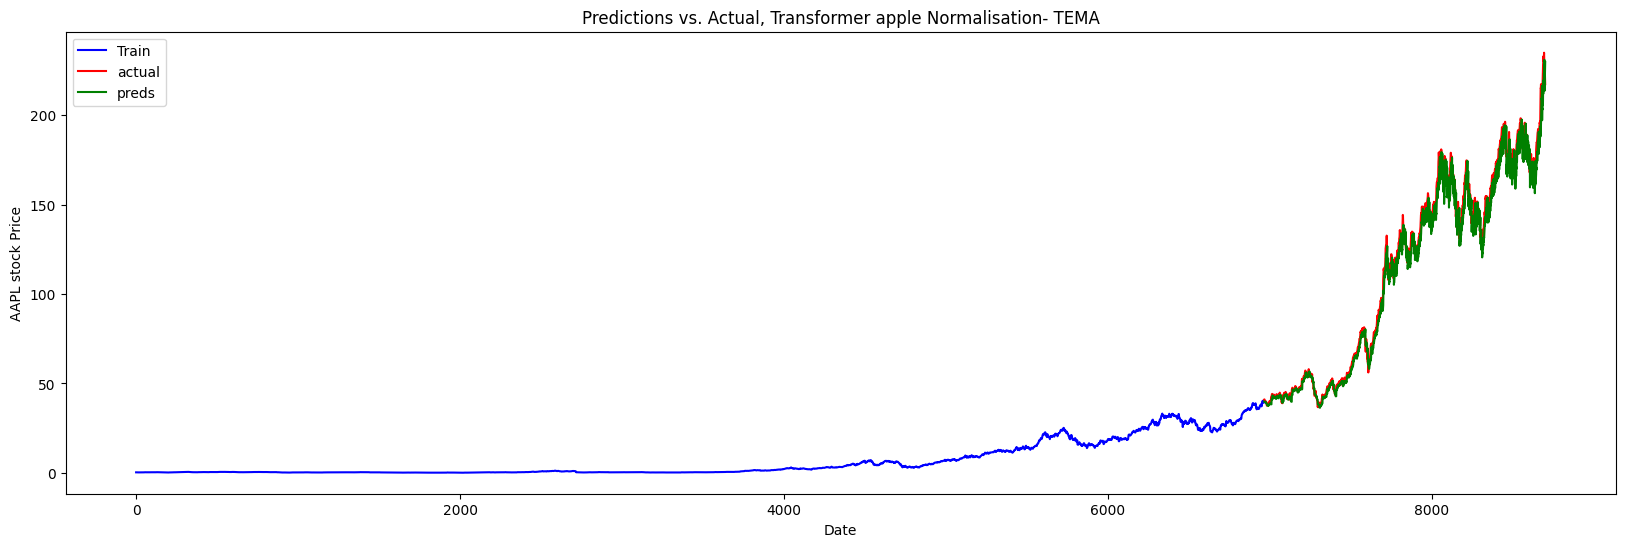

MAPE for TEMA: 0.03694945258691667
RMSE for TEMA: 5.820552439772555
MAE for TEMA: 4.3875547958786685
R-squared for TEMA: 0.9888303281675663
(1393, 5, 1)
(348, 5, 1)
[[[0.00092736]
  [0.00093282]
  [0.00093827]
  [0.00094629]
  [0.00094241]]

 [[0.00093282]
  [0.00093827]
  [0.00094629]
  [0.00094241]
  [0.00090569]]

 [[0.00093827]
  [0.00094629]
  [0.00094241]
  [0.00090569]
  [0.00085423]]

 ...

 [[0.1676974 ]
  [0.16942215]
  [0.17082278]
  [0.16806547]
  [0.16775965]]

 [[0.16942215]
  [0.17082278]
  [0.16806547]
  [0.16775965]
  [0.16895704]]

 [[0.17082278]
  [0.16806547]
  [0.16775965]
  [0.16895704]
  [0.17060314]]] [[0.00090569 0.00085423 0.00082728 0.00080894 0.00081389]
 [0.00085423 0.00082728 0.00080894 0.00081389 0.00078375]
 [0.00082728 0.00080894 0.00081389 0.00078375 0.00075035]
 ...
 [0.16895704 0.17060314 0.17105339 0.16940226 0.16824965]
 [0.17060314 0.17105339 0.16940226 0.16824965 0.16744551]
 [0.17105339 0.16940226 0.16824965 0.16744551 0.16854266]]
[[[0.1692267 

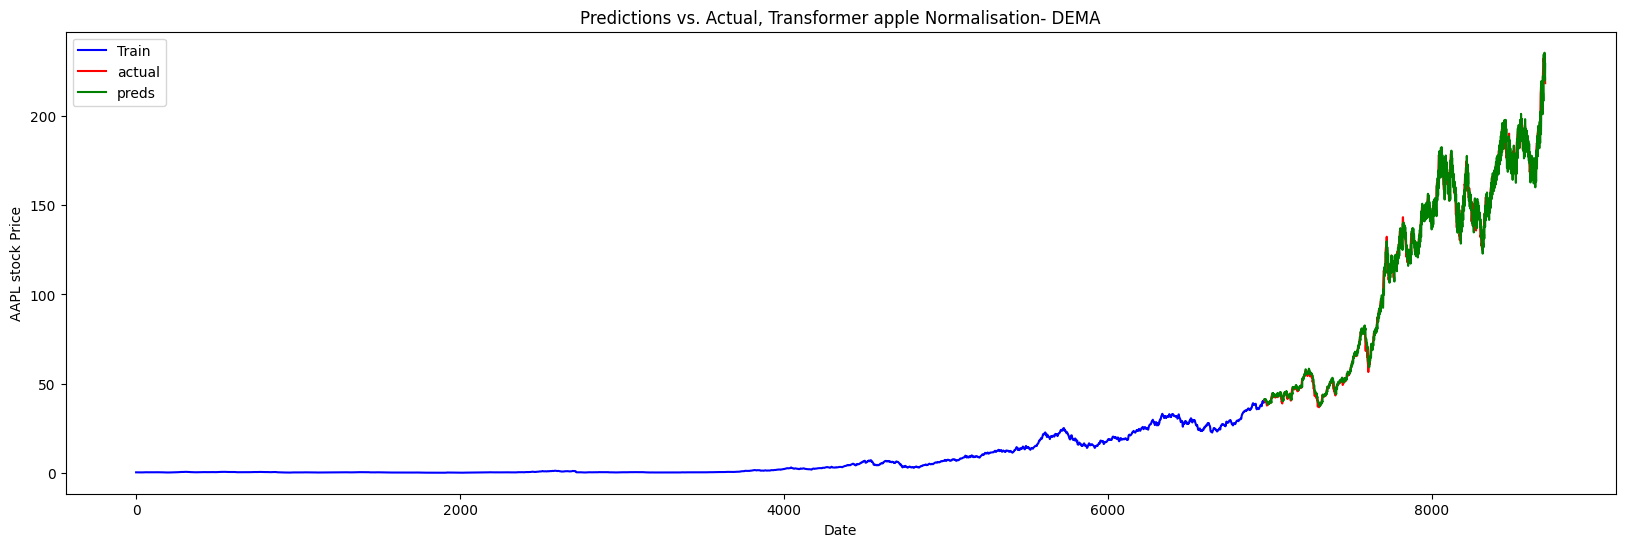

MAPE for DEMA: 0.02821256578699485
RMSE for DEMA: 4.780433215629641
MAE for DEMA: 3.3357146865819223
R-squared for DEMA: 0.9924683244326009
(1392, 5, 1)
(348, 5, 1)
[[[0.00092156]
  [0.00088446]
  [0.00085536]
  [0.00083137]
  [0.00082498]]

 [[0.00088446]
  [0.00085536]
  [0.00083137]
  [0.00082498]
  [0.00080483]]

 [[0.00085536]
  [0.00083137]
  [0.00082498]
  [0.00080483]
  [0.00078052]]

 ...

 [[0.16789509]
  [0.16950269]
  [0.17074277]
  [0.16964597]
  [0.16934078]]

 [[0.16950269]
  [0.17074277]
  [0.16964597]
  [0.16934078]
  [0.16980644]]

 [[0.17074277]
  [0.16964597]
  [0.16934078]
  [0.16980644]
  [0.17082445]]] [[0.00080483 0.00078052 0.00078564 0.0007786  0.00078052]
 [0.00078052 0.00078564 0.0007786  0.00078052 0.00078852]
 [0.00078564 0.0007786  0.00078052 0.00078852 0.00079619]
 ...
 [0.16980644 0.17082445 0.17150073 0.17107805 0.17034446]
 [0.17082445 0.17150073 0.17107805 0.17034446 0.16950556]
 [0.17150073 0.17107805 0.17034446 0.16950556 0.16977635]]
[[[0.17053717

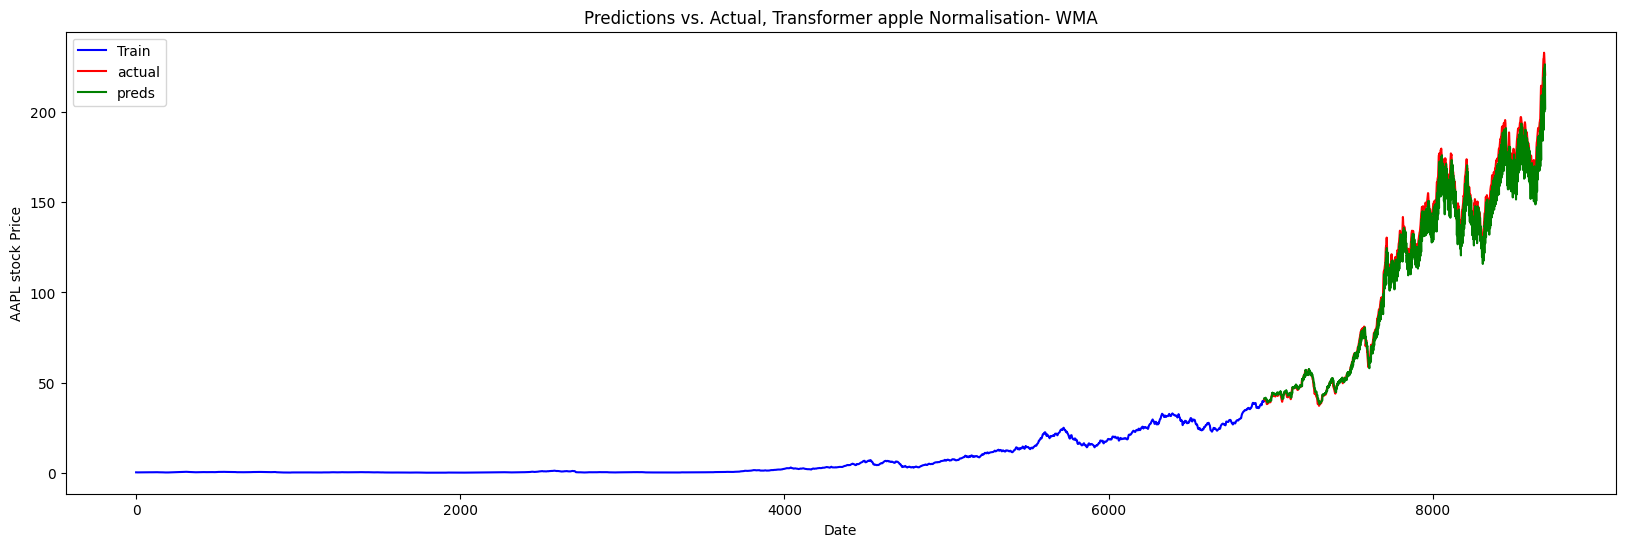

MAPE for WMA: 0.04071613157739533
RMSE for WMA: 8.119614633325025
MAE for WMA: 5.412791278152174
R-squared for WMA: 0.9782024137477793
(1393, 5, 1)
(348, 5, 1)
[[[0.00092931]
  [0.00093305]
  [0.00093716]
  [0.0009431 ]
  [0.00094225]]

 [[0.00093305]
  [0.00093716]
  [0.0009431 ]
  [0.00094225]
  [0.00092082]]

 [[0.00093716]
  [0.0009431 ]
  [0.00094225]
  [0.00092082]
  [0.00088728]]

 ...

 [[0.16762617]
  [0.16912496]
  [0.17047644]
  [0.16931407]
  [0.16931561]]

 [[0.16912496]
  [0.17047644]
  [0.16931407]
  [0.16931561]
  [0.17016858]]

 [[0.17047644]
  [0.16931407]
  [0.16931561]
  [0.17016858]
  [0.1713663 ]]] [[0.00092082 0.00088728 0.00086491 0.00084679 0.00084274]
 [0.00088728 0.00086491 0.00084679 0.00084274 0.00081917]
 [0.00086491 0.00084679 0.00084274 0.00081917 0.00079223]
 ...
 [0.17016858 0.1713663  0.17193112 0.17119691 0.17057803]
 [0.1713663  0.17193112 0.17119691 0.17057803 0.1700612 ]
 [0.17193112 0.17119691 0.17057803 0.1700612  0.17064047]]
[[[0.17114872]
  [

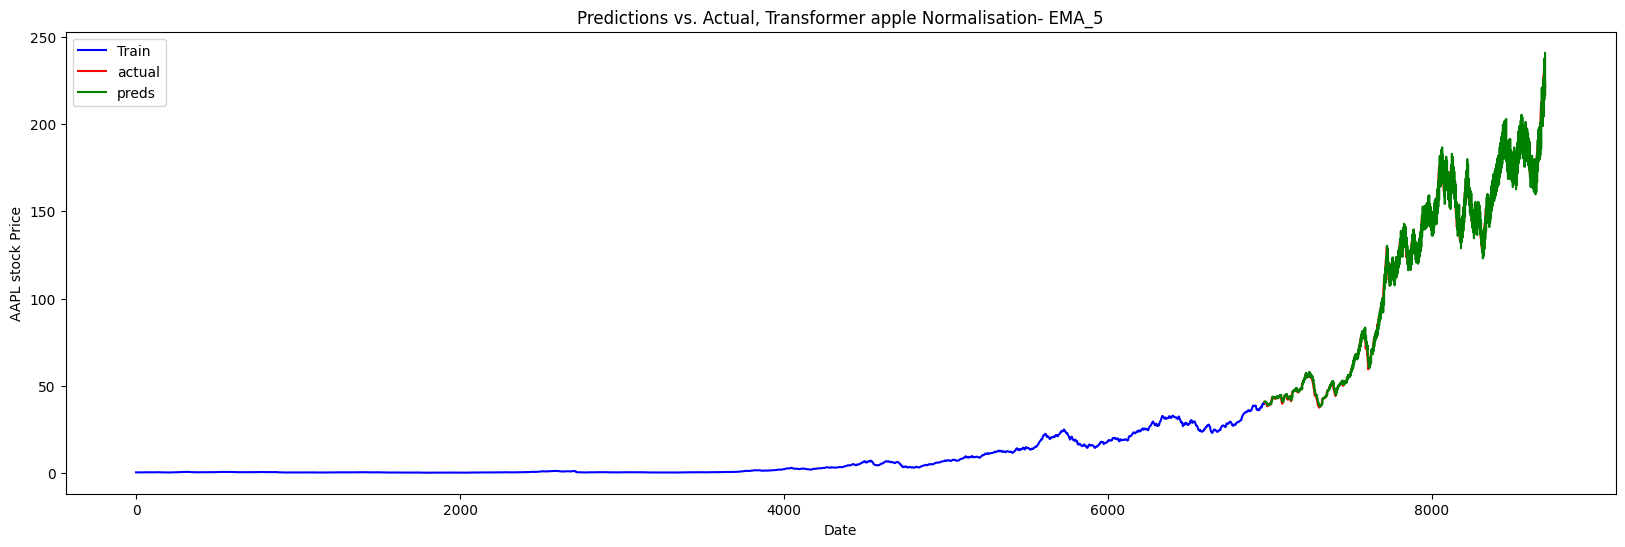

MAPE for EMA_5: 0.02553316445297336
RMSE for EMA_5: 4.81028931802066
MAE for EMA_5: 3.1663103645161983
R-squared for EMA_5: 0.9923365684232732
(1392, 5, 1)
(348, 5, 1)
[[[0.00093397]
  [0.00090991]
  [0.00088489]
  [0.00085602]
  [0.00083485]]

 [[0.00090991]
  [0.00088489]
  [0.00085602]
  [0.00083485]
  [0.00081367]]

 [[0.00088489]
  [0.00085602]
  [0.00083485]
  [0.00081367]
  [0.00079732]]

 ...

 [[0.16719805]
  [0.1693602 ]
  [0.17020523]
  [0.17015134]
  [0.17038631]]

 [[0.1693602 ]
  [0.17020523]
  [0.17015134]
  [0.17038631]
  [0.1706105 ]]

 [[0.17020523]
  [0.17015134]
  [0.17038631]
  [0.1706105 ]
  [0.17093816]]] [[0.00081367 0.00079732 0.00079539 0.00078769 0.00077903]
 [0.00079732 0.00079539 0.00078769 0.00077903 0.0007848 ]
 [0.00079539 0.00078769 0.00077903 0.0007848  0.00079828]
 ...
 [0.1706105  0.17093816 0.17091445 0.17146199 0.17146631]
 [0.17093816 0.17091445 0.17146199 0.17146631 0.17089721]
 [0.17091445 0.17146199 0.17146631 0.17089721 0.17050487]]
[[[0.17059

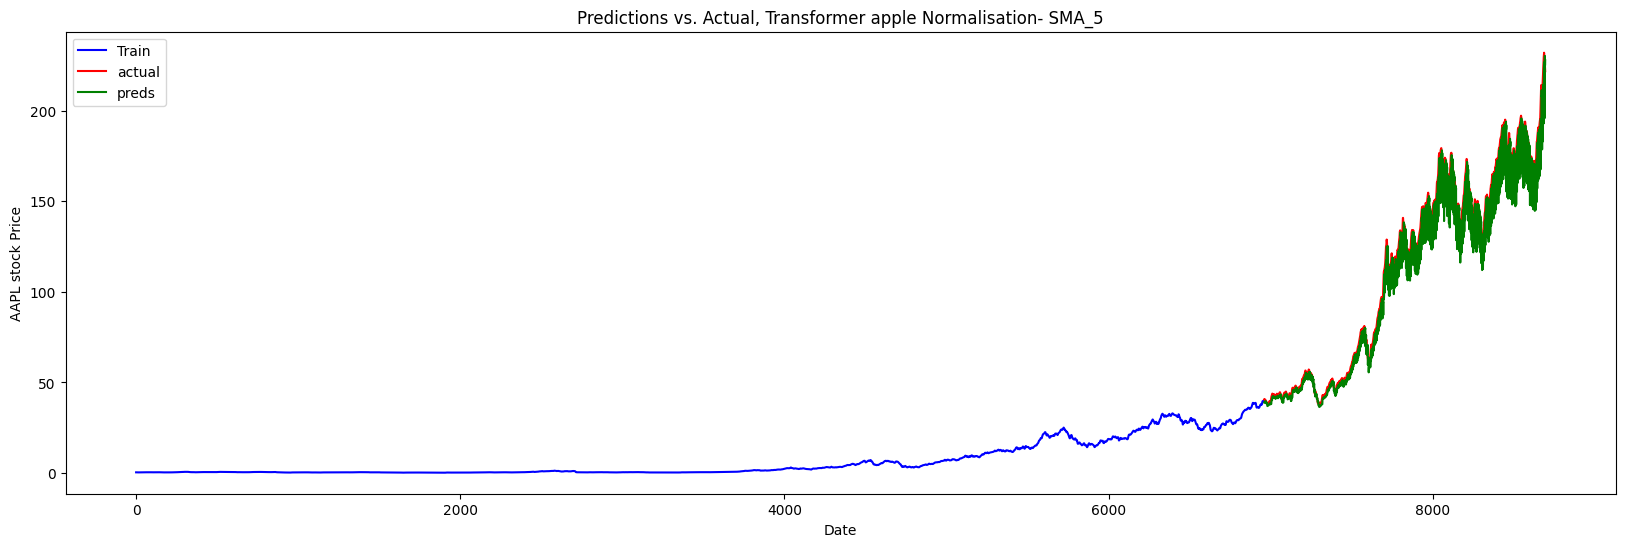

MAPE for SMA_5: 0.044976538061325344
RMSE for SMA_5: 8.536574380163247
MAE for SMA_5: 5.395167380146596
R-squared for SMA_5: 0.9758826224011808
(1393, 5, 1)
(348, 5, 1)
[[[0.00093212]
  [0.00093447]
  [0.00093727]
  [0.00094135]
  [0.00094202]]

 [[0.00093447]
  [0.00093727]
  [0.00094135]
  [0.00094202]
  [0.000931  ]]

 [[0.00093727]
  [0.00094135]
  [0.00094202]
  [0.000931  ]
  [0.00091131]]

 ...

 [[0.16821211]
  [0.16942745]
  [0.17061708]
  [0.17044674]
  [0.17073775]]

 [[0.16942745]
  [0.17061708]
  [0.17044674]
  [0.17073775]
  [0.17144805]]

 [[0.17061708]
  [0.17044674]
  [0.17073775]
  [0.17144805]
  [0.1723779 ]]] [[0.000931   0.00091131 0.0008952  0.00088024 0.00087245]
 [0.00091131 0.0008952  0.00088024 0.00087245 0.00085451]
 [0.0008952  0.00088024 0.00087245 0.00085451 0.00083361]
 ...
 [0.17144805 0.1723779  0.17300916 0.17290999 0.17275711]
 [0.1723779  0.17300916 0.17290999 0.17275711 0.17257425]
 [0.17300916 0.17290999 0.17275711 0.17257425 0.1729367 ]]
[[[0.1734

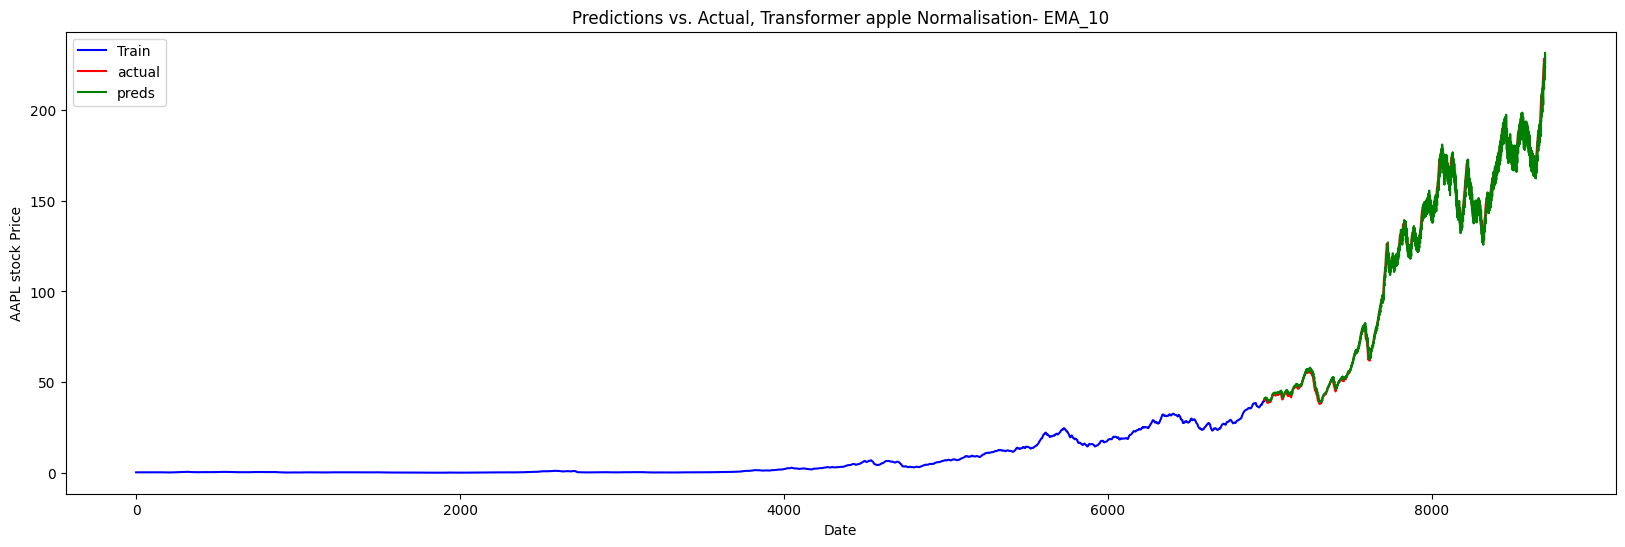

MAPE for EMA_10: 0.02490606453882584
RMSE for EMA_10: 4.006471047573294
MAE for EMA_10: 2.921735644927425
R-squared for EMA_10: 0.9946548537205451
(1391, 5, 1)
(348, 5, 1)
[[[0.00079158]
  [0.00079361]
  [0.00079127]
  [0.00079159]
  [0.00079214]]

 [[0.00079361]
  [0.00079127]
  [0.00079159]
  [0.00079214]
  [0.0007923 ]]

 [[0.00079127]
  [0.00079159]
  [0.00079214]
  [0.0007923 ]
  [0.000791  ]]

 ...

 [[0.1676976 ]
  [0.16838236]
  [0.16842213]
  [0.16866105]
  [0.1692718 ]]

 [[0.16838236]
  [0.16842213]
  [0.16866105]
  [0.1692718 ]
  [0.17004621]]

 [[0.16842213]
  [0.16866105]
  [0.1692718 ]
  [0.17004621]
  [0.1702297 ]]] [[0.0007923  0.000791   0.00079072 0.00079094 0.00079116]
 [0.000791   0.00079072 0.00079094 0.00079116 0.00079112]
 [0.00079072 0.00079094 0.00079116 0.00079112 0.00079122]
 ...
 [0.17004621 0.1702297  0.17026399 0.17027912 0.17029648]
 [0.1702297  0.17026399 0.17027912 0.17029648 0.17031857]
 [0.17026399 0.17027912 0.17029648 0.17031857 0.17036003]]
[[[0.1

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/2130994814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 6.6899e-04 - mae: 0.0154 - mape: 1772.9774 - val_loss: 8.3575e-04 - val_mae: 0.0206 - val_mape: 3.7884
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7795e-05 - mae: 0.0026 - mape: 208.0958 - val_loss: 3.5329e-04 - val_mae: 0.0133 - val_mape: 2.7380
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8988e-05 - mae: 0.0028 - mape: 493.8696 - val_loss: 3.1192e-04 - val_mae: 0.0122 - val_mape: 2.4188
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1698e-05 - mae: 0.0021 - mape: 499.1974 - val_loss: 3.1901e-04 - val_mae: 0.0127 - val_mape: 2.6212
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3207e-05 - mae: 0.0024 - mape: 323.4696 - val_loss: 2.4396e-04 - val_mae: 0.0108 - val_mape: 2.1287
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0486e-05 - mae: 0.0020 - mape: 476.5834 - val_loss: 3.1343e-04 - val_mae: 0.0126 - val_mape: 2.5812
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━

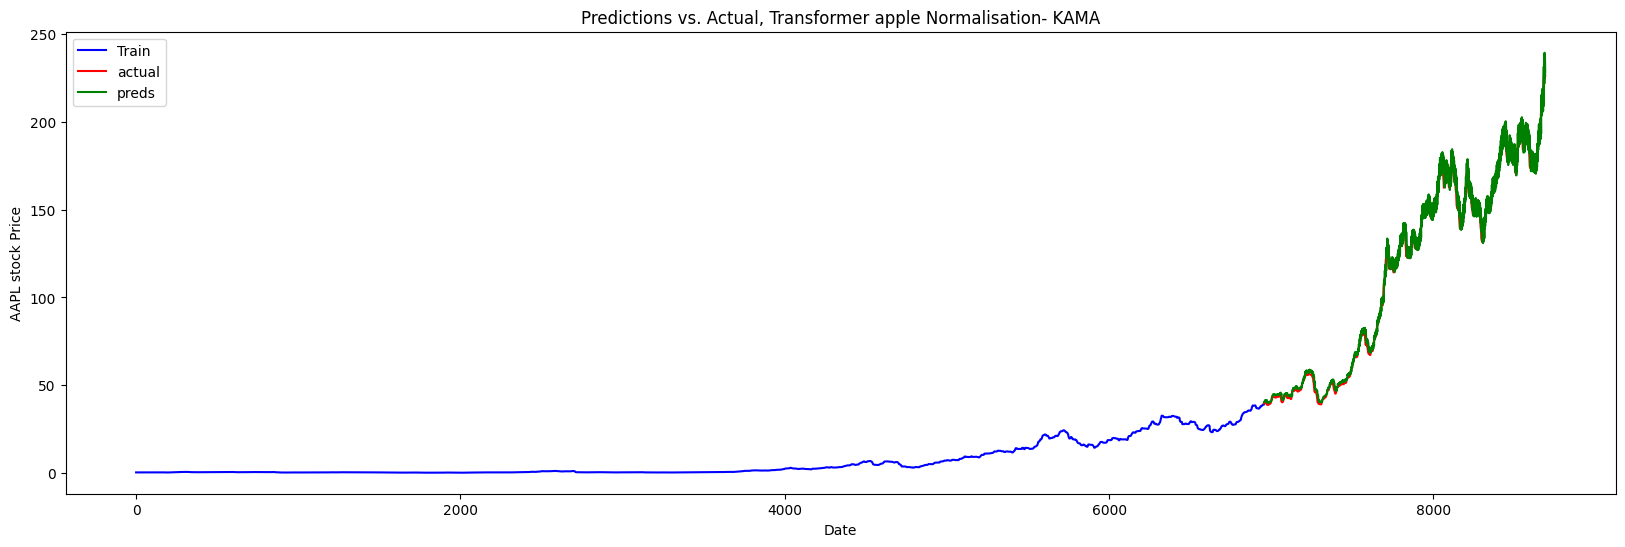

MAPE for KAMA: 0.030898089491938157
RMSE for KAMA: 4.650690271875536
MAE for KAMA: 3.4839341353016002
R-squared for KAMA: 0.9927808157103178
(1391, 5, 1)
(348, 5, 1)
[[[0.00085419]
  [0.00084057]
  [0.00082209]
  [0.00080702]
  [0.00079924]]

 [[0.00084057]
  [0.00082209]
  [0.00080702]
  [0.00079924]
  [0.00079778]]

 [[0.00082209]
  [0.00080702]
  [0.00079924]
  [0.00079778]
  [0.00079097]]

 ...

 [[0.16726669]
  [0.16809457]
  [0.16861309]
  [0.16948236]
  [0.17069368]]

 [[0.16809457]
  [0.16861309]
  [0.16948236]
  [0.17069368]
  [0.17195184]]

 [[0.16861309]
  [0.16948236]
  [0.17069368]
  [0.17195184]
  [0.17236687]]] [[0.00079778 0.00079097 0.00078708 0.00078367 0.00078659]
 [0.00079097 0.00078708 0.00078367 0.00078659 0.00079145]
 [0.00078708 0.00078367 0.00078659 0.00079145 0.00079145]
 ...
 [0.17195184 0.17236687 0.17261632 0.17273724 0.17256295]
 [0.17236687 0.17261632 0.17273724 0.17256295 0.17253027]
 [0.17261632 0.17273724 0.17256295 0.17253027 0.17241262]]
[[[0.1728429

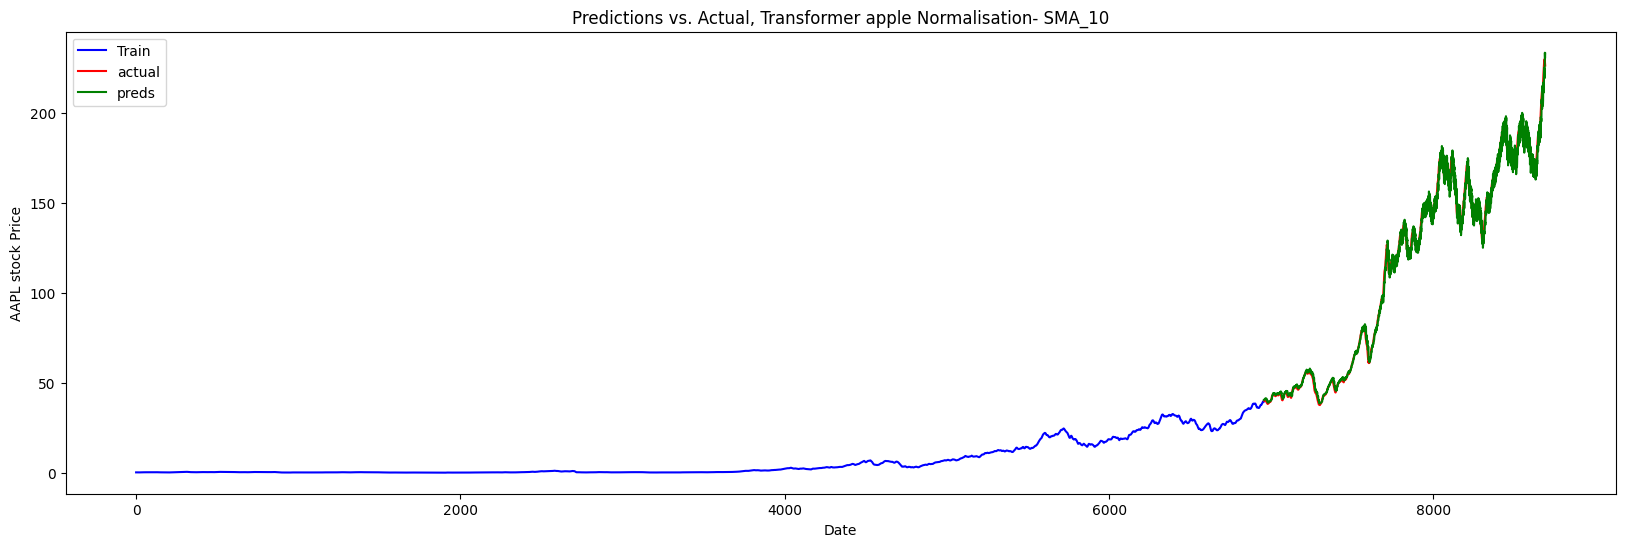

MAPE for SMA_10: 0.023500756625847496
RMSE for SMA_10: 3.7661726662757293
MAE for SMA_10: 2.756788759341185
R-squared for SMA_10: 0.995283334073995
(1393, 5, 1)
(348, 5, 1)
[[[0.00094509]
  [0.00094698]
  [0.00094938]
  [0.00095294]
  [0.00095428]]

 [[0.00094698]
  [0.00094938]
  [0.00095294]
  [0.00095428]
  [0.00094699]]

 [[0.00094938]
  [0.00095294]
  [0.00095428]
  [0.00094699]
  [0.00093231]]

 ...

 [[0.16478962]
  [0.16583837]
  [0.16700905]
  [0.16725938]
  [0.16767641]]

 [[0.16583837]
  [0.16700905]
  [0.16725938]
  [0.16767641]
  [0.16836565]]

 [[0.16700905]
  [0.16725938]
  [0.16767641]
  [0.16836565]
  [0.16921192]]] [[0.00094699 0.00093231 0.00091865 0.00090461 0.00089483]
 [0.00093231 0.00091865 0.00090461 0.00089483 0.00087718]
 [0.00091865 0.00090461 0.00089483 0.00087718 0.00085615]
 ...
 [0.16836565 0.16921192 0.17011756 0.17058399 0.17102193]
 [0.16921192 0.17011756 0.17058399 0.17102193 0.17128986]
 [0.17011756 0.17058399 0.17102193 0.17128986 0.17139581]]
[[[0.

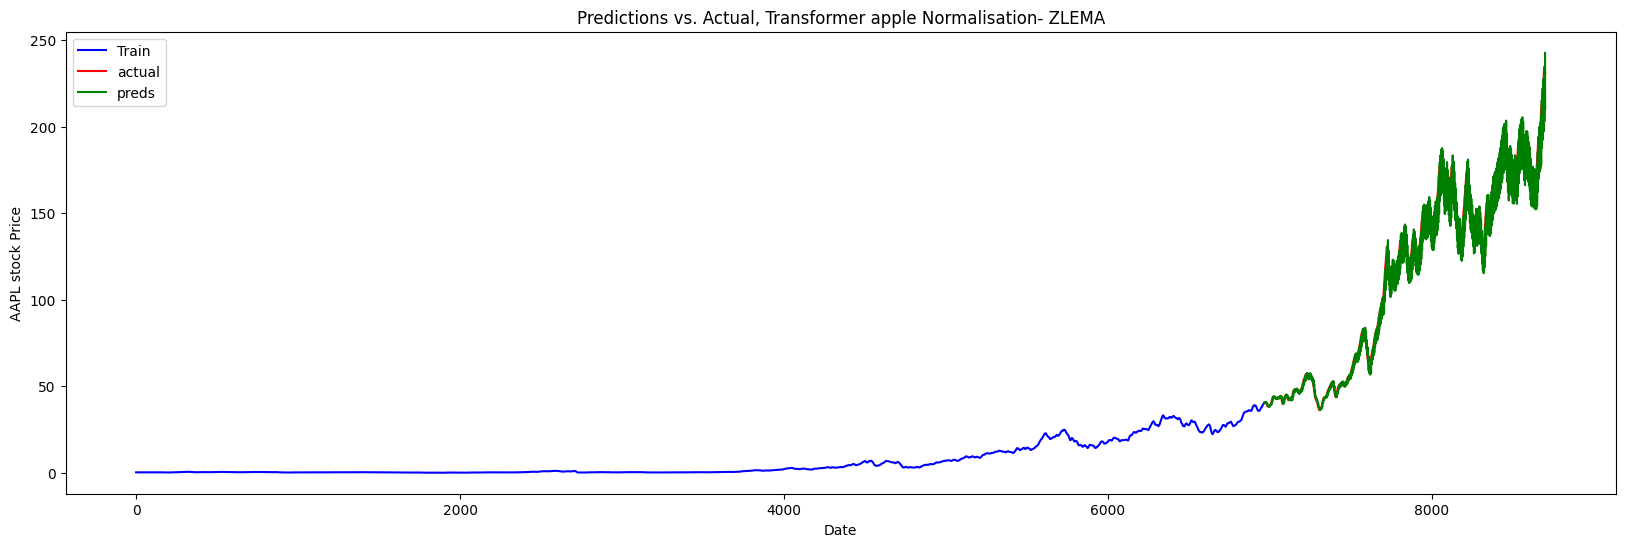

MAPE for ZLEMA: 0.041425995319582076
RMSE for ZLEMA: 7.913841246439074
MAE for ZLEMA: 5.50189715507262
R-squared for ZLEMA: 0.9794263446480527
(1388, 5, 1)
(347, 5, 1)
[[[0.00083931]
  [0.00083034]
  [0.00082914]
  [0.00082794]
  [0.00082654]]

 [[0.00083034]
  [0.00082914]
  [0.00082794]
  [0.00082654]
  [0.00082528]]

 [[0.00082914]
  [0.00082794]
  [0.00082654]
  [0.00082528]
  [0.00082754]]

 ...

 [[0.17093942]
  [0.17167988]
  [0.17254841]
  [0.172707  ]
  [0.17331424]]

 [[0.17167988]
  [0.17254841]
  [0.172707  ]
  [0.17331424]
  [0.17387431]]

 [[0.17254841]
  [0.172707  ]
  [0.17331424]
  [0.17387431]
  [0.17435867]]] [[0.00082528 0.00082754 0.00082778 0.00082663 0.00082778]
 [0.00082754 0.00082778 0.00082663 0.00082778 0.00082834]
 [0.00082778 0.00082663 0.00082778 0.00082834 0.00082774]
 ...
 [0.17387431 0.17435867 0.1749578  0.17562244 0.17620285]
 [0.17435867 0.1749578  0.17562244 0.17620285 0.17691661]
 [0.1749578  0.17562244 0.17620285 0.17691661 0.17763709]]
[[[0.17872

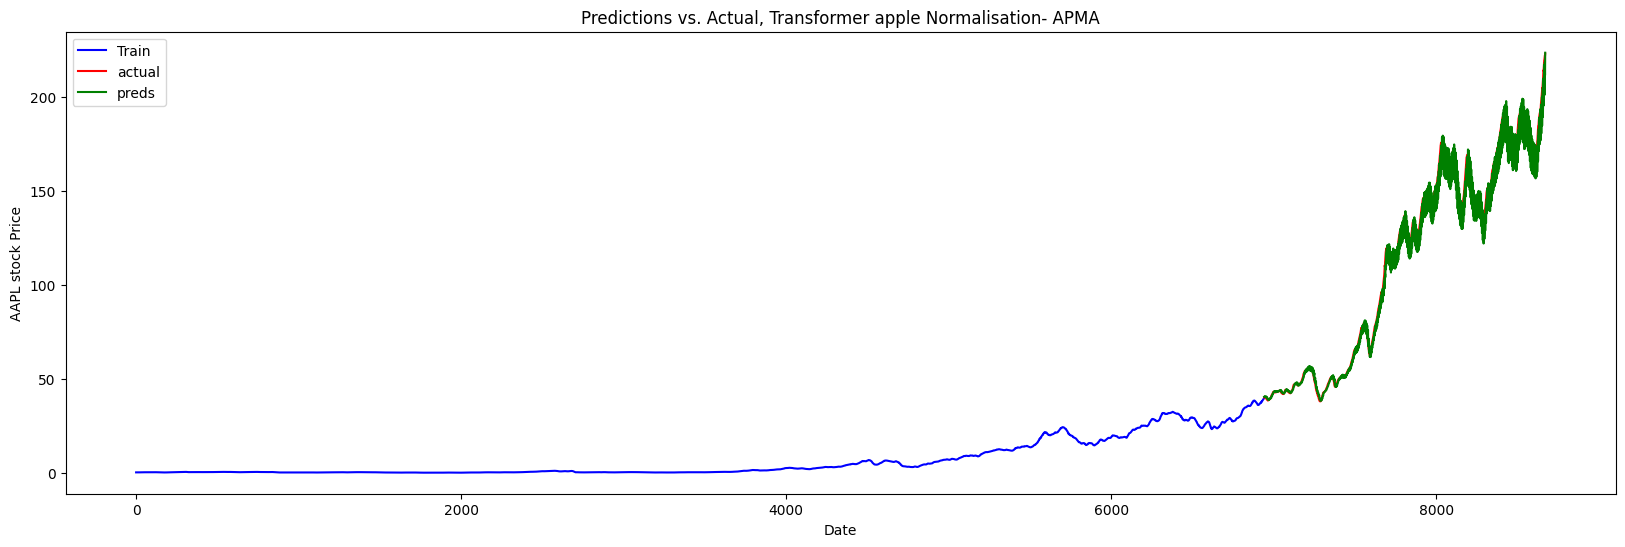

MAPE for APMA: 0.027309288055559634
RMSE for APMA: 5.215743776695582
MAE for APMA: 3.529040175199868
R-squared for APMA: 0.9908379580138277


In [6]:
for j in range(len(list_type_used)):
    try:
        dataset_ma = apply_moving_average(dataset, j)
        dataset_ma.dropna(inplace=True)

        normaliza_bool_update = True
        type_normalisation_update = MinMaxScaler()

        data = ETL(datainput=dataset_ma, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=False)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer apple Normalisation- {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")

Not Indicator

[*********************100%%**********************]  1 of 1 completed

data shape: (8708, 1)
train shape: (6966, 1, 1) test shape: (1742, 1, 1)
(1393, 5, 1)
(348, 5, 1)
[[[0.0009344 ]
  [0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]]

 [[0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]
  [0.00087734]]

 [[0.00094391]
  [0.00095342]
  [0.00093916]
  [0.00087734]
  [0.00082028]]

 ...

 [[0.16866736]
  [0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]]

 [[0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]
  [0.16977514]]

 [[0.17106399]
  [0.16494993]
  [0.16725068]
  [0.16977514]
  [0.17163919]]] [[0.00087734 0.00082028 0.00082028 0.00081077 0.00083454]
 [0.00082028 0.00082028 0.00081077 0.00083454 0.00077272]
 [0.00082028 0.00081077 0.00083454 0.00077272 0.00073944]
 ...
 [0.16977514 0.17163919 0.17094682 0.16765545 0.16727199]
 [0.17163919 0.17094682 0.16765545 0.16727199 0.16696309]
 [0.17094682 0.16765545 0.16727199 0.16696309 0.16970057]]
[[[0.16978579]
  [0.17150071]
  [0.17303456]
  [0.17350323]
  [0.17419559]]

 [[


/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/1861617811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.6105e-04 - mae: 0.0106 - mape: 2371.3914 - val_loss: 5.2299e-04 - val_mae: 0.0167 - val_mape: 3.5083
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8026e-05 - mae: 0.0026 - mape: 286.4266 - val_loss: 5.5124e-04 - val_mae: 0.0168 - val_mape: 3.4760
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5777e-05 - mae: 0.0024 - mape: 205.6284 - val_loss: 4.5695e-04 - val_mae: 0.0153 - val_mape: 3.1732
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3035e-05 - mae: 0.0022 - mape: 427.8537 - val_loss: 3.9786e-04 - val_mae: 0.0140 - val_mape: 2.9032
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1084e-05 - mae: 0.0020 - mape: 464.5714 - val_loss: 3.9342e-04 - val_mae: 0.0140 - val_mape: 2.9237
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0448e-05 - mae: 0.0020 - mape: 702.2280 - val_loss: 4.1843e-04 - val_mae: 0.0145 - val_mape: 3.0362
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━

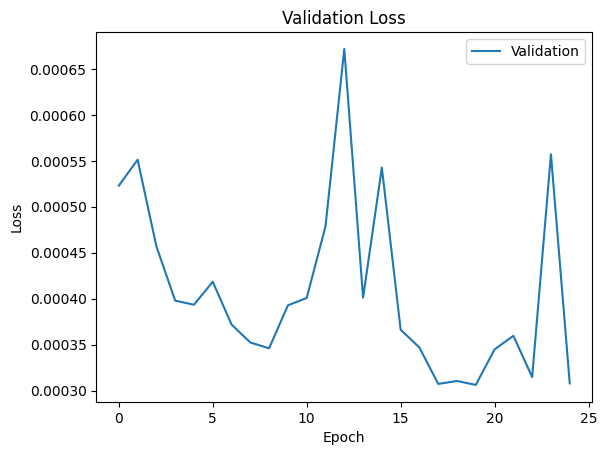

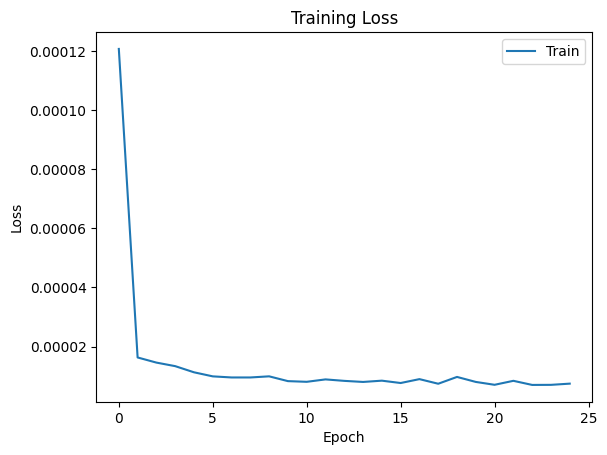

Minimum validation loss: 0.0003


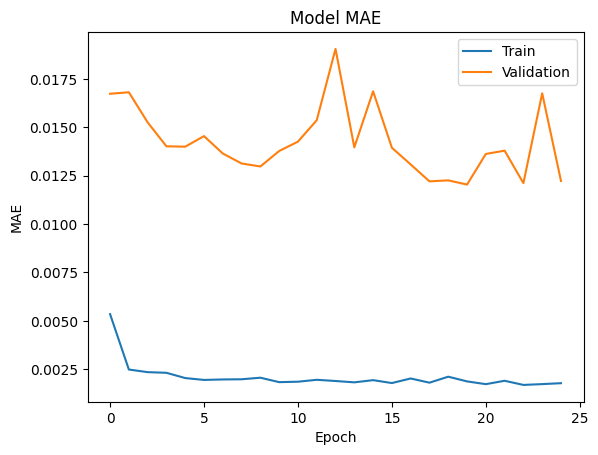

Minimum validation MAE: 0.0120
Minimum validation MAPE: 2.5073
normalization convert active
plot_train shape: (6965, 1)
plot_test shape: (1735, 1)
plot_preds shape: (1735, 1)


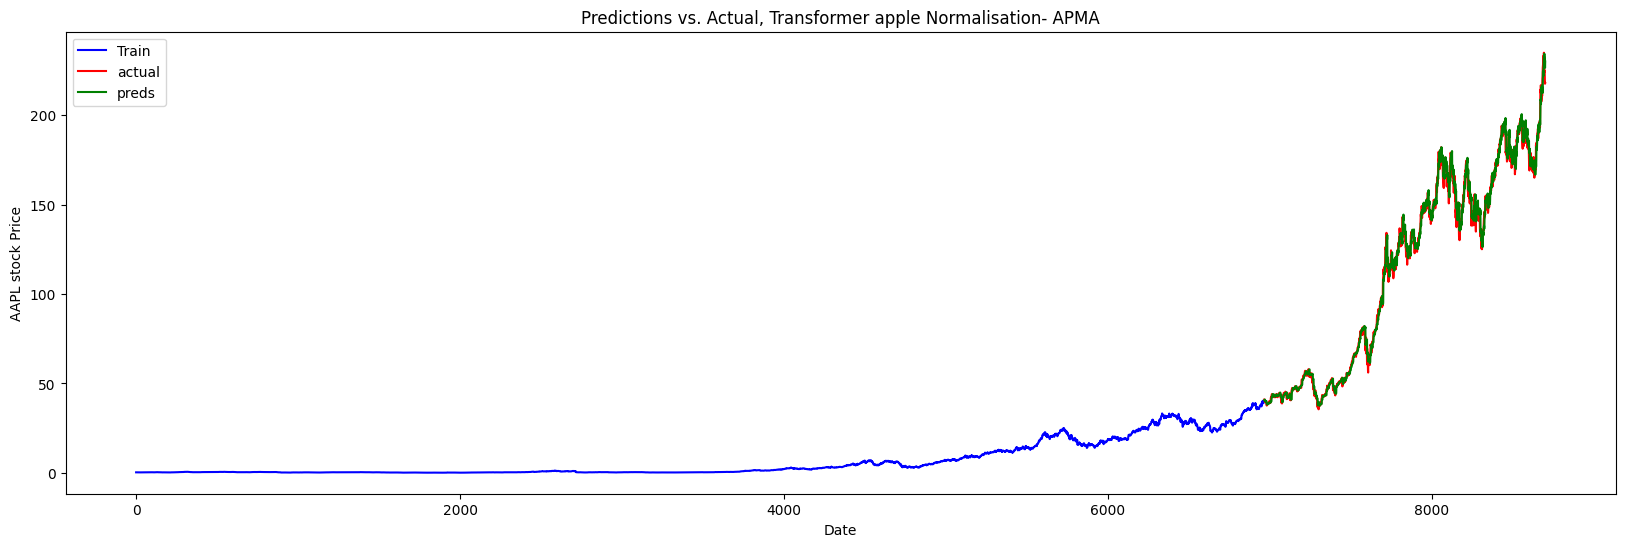

Initial lengths - actual: 348, predictions: 348
MAPE for APMA: 0.02507420389807208
RMSE for APMA: 4.1244000147218065
MAE for APMA: 2.814108418870246
R-squared for APMA: 0.9943961725696653
data shape: (8708, 1)
train shape: (6966, 1, 1) test shape: (1742, 1, 1)
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]]

 [[ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]]

 [[ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]]

 ...

 [[39.70249939]
  [40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]]

 [[40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]]

 [[40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]
  [40.40000153]]] [[ 0.32142901  0.308036    0.308036    0.30580401  0.31138399]
 [ 0.308036    0.308036    0.30580401  0.31138399  0.296875  ]
 [ 0.308036    0.30580401  0.31138399  0.296875    0.28906301]
 ...
 [39.96250153 40.40000

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/1861617811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 36.9244 - mae: 2.3988 - mape: 75.0305 - val_loss: 24.5178 - val_mae: 3.5159 - val_mape: 3.1180
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0207 - mae: 0.4704 - mape: 11.4317 - val_loss: 27.4962 - val_mae: 3.8201 - val_mape: 3.4184
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7862 - mae: 0.4157 - mape: 11.1058 - val_loss: 20.7706 - val_mae: 3.2064 - val_mape: 2.8487
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6750 - mae: 0.3908 - mape: 11.1320 - val_loss: 20.5168 - val_mae: 3.1824 - val_mape: 2.8265
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5425 - mae: 0.3474 - mape: 9.8664 - val_loss: 21.9465 - val_mae: 3.3645 - val_mape: 2.9970
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4915 - mae: 0.3407 - mape: 10.9600 - val_loss: 19.6041 - val_mae: 3.1391 - val_mape: 2.7893
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4753 - mae: 0.3320 - mape

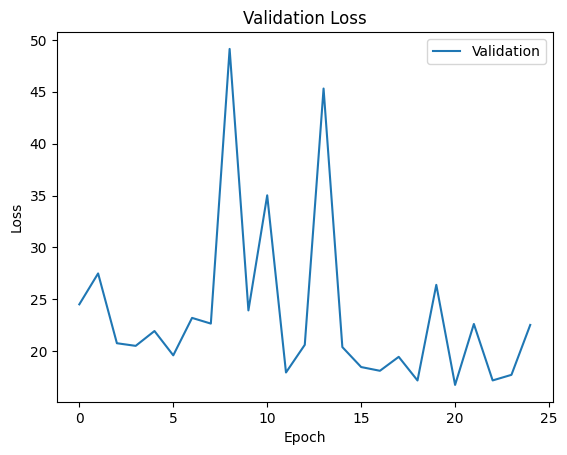

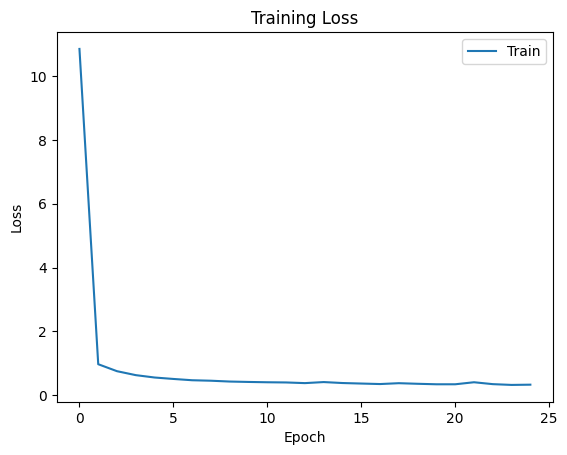

Minimum validation loss: 16.7532


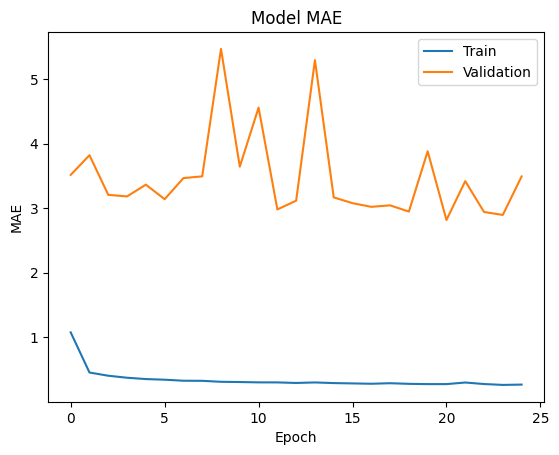

Minimum validation MAE: 2.8174
Minimum validation MAPE: 2.5027
plot_train shape: (6965, 1)
plot_test shape: (1735, 1)
plot_preds shape: (1735, 1)


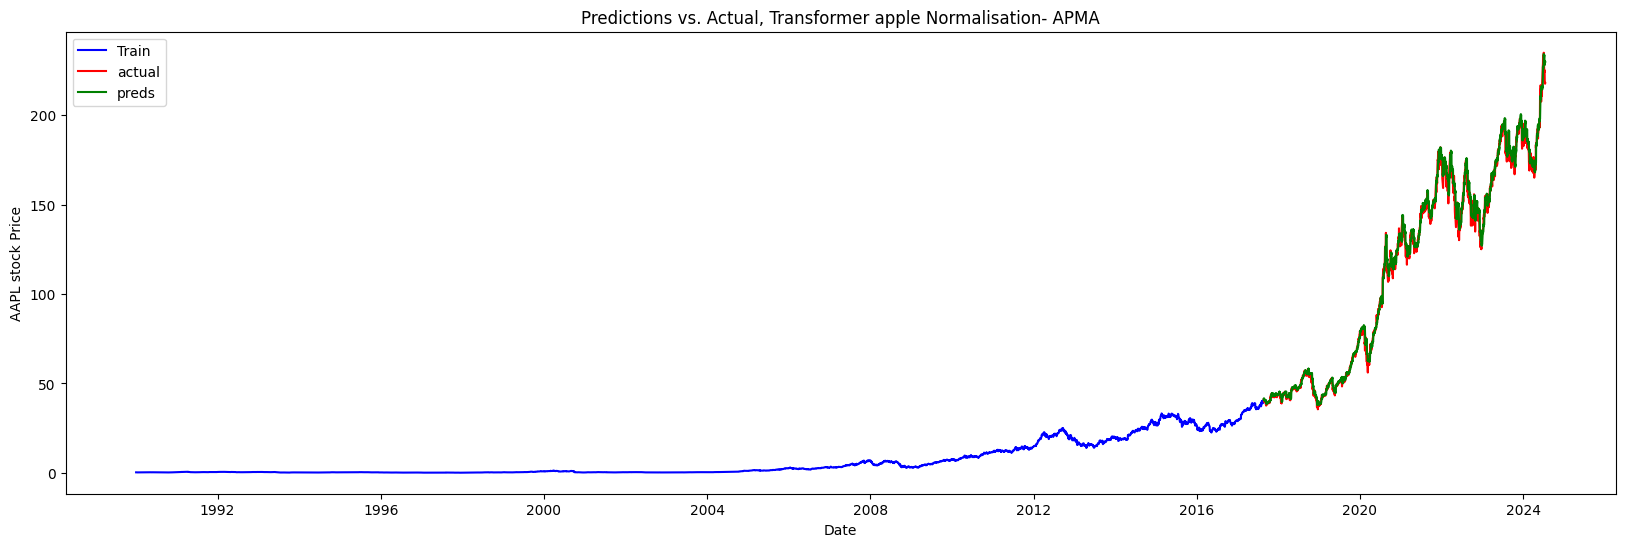

Initial lengths - actual: 348, predictions: 348
MAPE for APMA: 0.025559862983547045
RMSE for APMA: 4.175532478040175
MAE for APMA: 2.8568205318231694
R-squared for APMA: 0.9942563637823194
Done


In [24]:
n = 0
ticker = 'aapl'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]
while (n < 2):
    try:
        dataset.dropna(inplace=True)
        if n == 0:
            normaliza_bool_update = True
        else:
            normaliza_bool_update = False
        type_normalisation_update = MinMaxScaler()

        data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=True)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer apple Normalisation- {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
        if n == 1:
            print("Done")
        n += 1
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")

[*********************100%%**********************]  1 of 1 completed

(171, 5, 1)
(42, 5, 1)
[[[0.18445681]
  [0.19142554]
  [0.1901464 ]
  [0.19218424]
  [0.19263886]]

 [[0.19142554]
  [0.1901464 ]
  [0.19218424]
  [0.19263886]
  [0.19913912]]

 [[0.1901464 ]
  [0.19218424]
  [0.19263886]
  [0.19913912]
  [0.19249489]]

 ...

 [[0.57613679]
  [0.56439356]
  [0.56286081]
  [0.58053853]
  [0.57851161]]

 [[0.56439356]
  [0.56286081]
  [0.58053853]
  [0.57851161]
  [0.59598826]]

 [[0.56286081]
  [0.58053853]
  [0.57851161]
  [0.59598826]
  [0.57174903]]] [[0.19913912 0.19249489 0.17925474 0.15242497 0.1345346 ]
 [0.19249489 0.17925474 0.15242497 0.1345346  0.13737718]
 [0.17925474 0.15242497 0.1345346  0.13737718 0.10542872]
 ...
 [0.59598826 0.57174903 0.58091421 0.58900054 0.61268943]
 [0.57174903 0.58091421 0.58900054 0.61268943 0.6189667 ]
 [0.58091421 0.58900054 0.61268943 0.6189667  0.62179108]]
[[[0.60564911]
  [0.6189258 ]
  [0.60634421]
  [0.61064138]
  [0.61980435]]

 [[0.6189258 ]
  [0.60634421]
  [0.61064138]
  [0.61980435]
  [0.59996023]]

 


/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/1949360089.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1696 - mae: 0.3680 - mape: 128425.5312 - val_loss: 0.2707 - val_mae: 0.4965 - val_mape: 64.2756
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0468 - mae: 0.1764 - mape: 648165.6875 - val_loss: 0.2241 - val_mae: 0.4512 - val_mape: 58.3439
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0395 - mae: 0.1599 - mape: 847074.8750 - val_loss: 0.2019 - val_mae: 0.4275 - val_mape: 55.2157
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0328 - mae: 0.1457 - mape: 339111.7188 - val_loss: 0.1626 - val_mae: 0.3789 - val_mape: 48.6050
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0309 - mae: 0.1427 - mape: 559259.4375 - val_loss: 0.1731 - val_mae: 0.3946 - val_mape: 50.8758
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307 - mae: 0.1423 - mape: 695663.8125 - val_loss: 0.1490 - val_mae: 0.3644 - val_mape: 46.8743
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0261 - mae: 

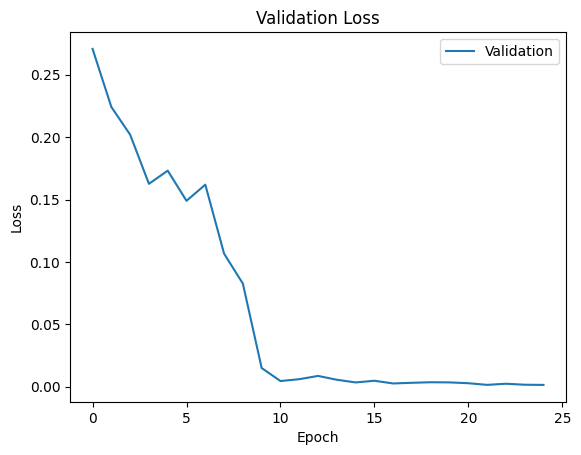

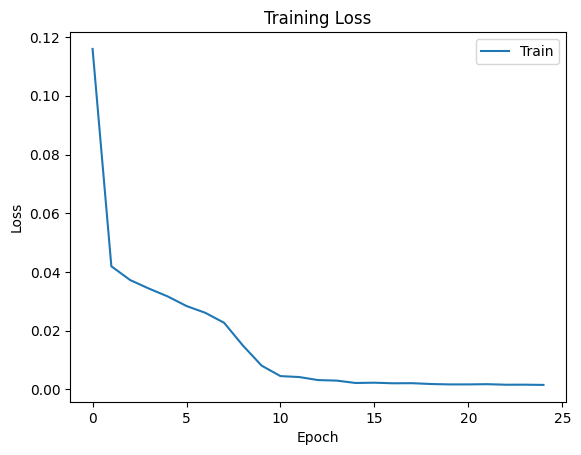

Minimum validation loss: 0.0014


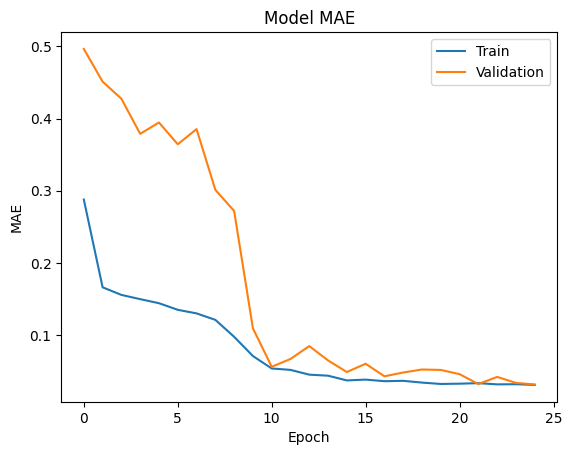

Minimum validation MAE: 0.0315
Minimum validation MAPE: 4.1374
normalization convert active
plot_train shape: (855, 1)
plot_test shape: (205, 1)
plot_preds shape: (205, 1)


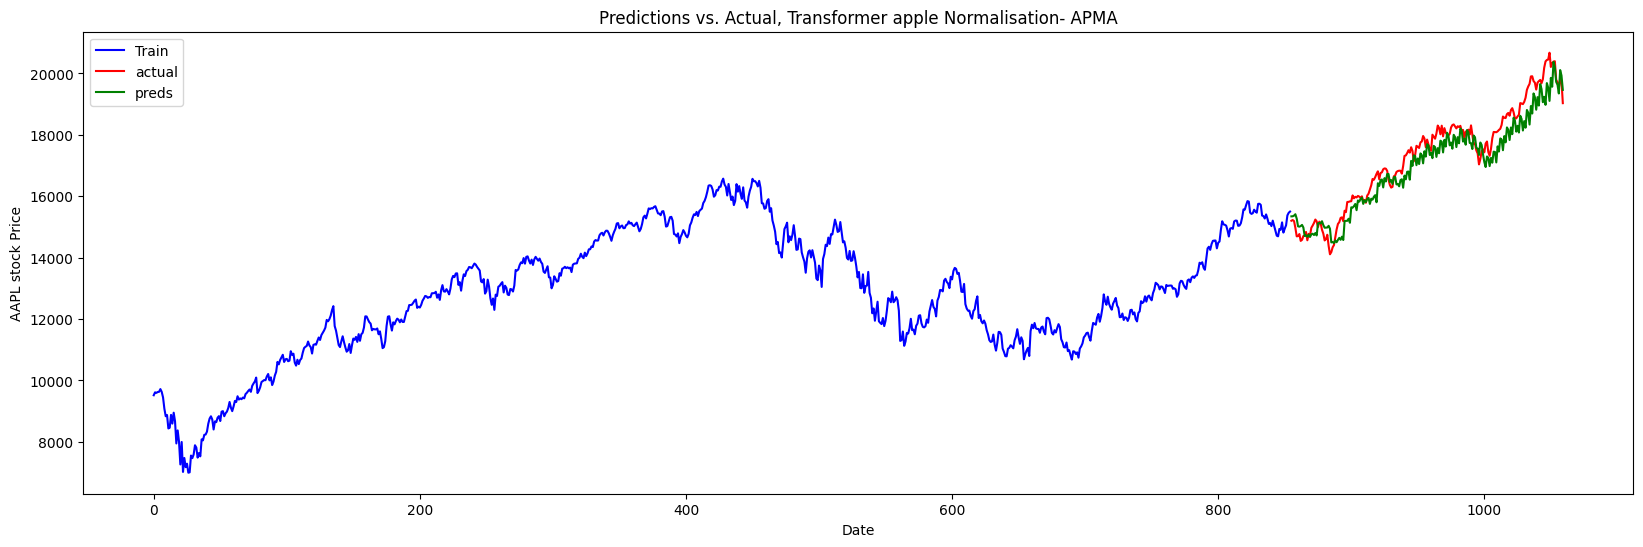

MAPE for APMA: 0.023206936928981507
RMSE for APMA: 500.34650411589115
MAE for APMA: 406.9882347470238
R-squared for APMA: 0.9090060457822187
(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9613.20019531]
  [ 9595.70019531]
  [ 9623.58007812]
  [ 9629.79980469]]

 [[ 9613.20019531]
  [ 9595.70019531]
  [ 9623.58007812]
  [ 9629.79980469]
  [ 9718.73046875]]

 [[ 9595.70019531]
  [ 9623.58007812]
  [ 9629.79980469]
  [ 9718.73046875]
  [ 9627.83007812]]

 ...

 [[14876.46972656]
  [14715.80957031]
  [14694.83984375]
  [14936.69042969]
  [14908.95996094]]

 [[14715.80957031]
  [14694.83984375]
  [14936.69042969]
  [14908.95996094]
  [15148.05957031]]

 [[14694.83984375]
  [14936.69042969]
  [14908.95996094]
  [15148.05957031]
  [14816.44042969]]] [[ 9718.73046875  9627.83007812  9446.69042969  9079.62988281
   8834.87011719]
 [ 9627.83007812  9446.69042969  9079.62988281  8834.87011719
   8873.75976562]
 [ 9446.69042969  9079.62988281  8834.87011719  8873.75976562
   8436.66992188]
 ...
 [1

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_10133/1949360089.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 123194960.0000 - mae: 10495.0020 - mape: 81.4025 - val_loss: 6396175.5000 - val_mae: 2278.0400 - val_mape: 13.1488
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2871600.7500 - mae: 1352.0942 - mape: 10.5756 - val_loss: 572356.5625 - val_mae: 635.5206 - val_mape: 3.7100
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1578841.5000 - mae: 987.1436 - mape: 7.7455 - val_loss: 268983.0000 - val_mae: 430.1058 - val_mape: 2.4868
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1483828.6250 - mae: 945.3862 - mape: 7.4141 - val_loss: 145672.7344 - val_mae: 311.7663 - val_mape: 1.8246
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1474703.0000 - mae: 951.9047 - mape: 7.4022 - val_loss: 160077.6875 - val_mae: 325.8454 - val_mape: 1.9022
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1401504.0000 - mae: 923.4625 - mape: 7.2644 - val_loss: 155582.4375 - val_mae: 322.0299 - val_mape: 1.8814
Epoch 7/25

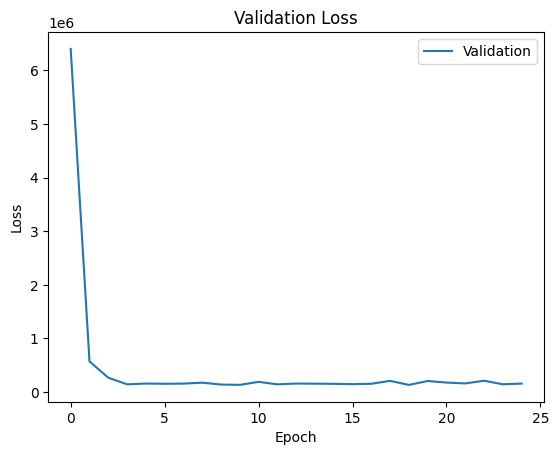

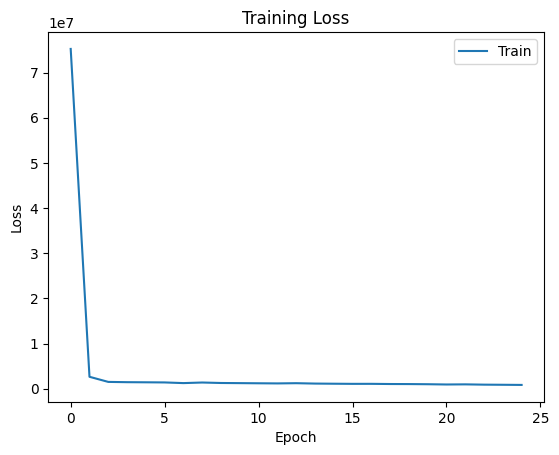

Minimum validation loss: 134612.1250


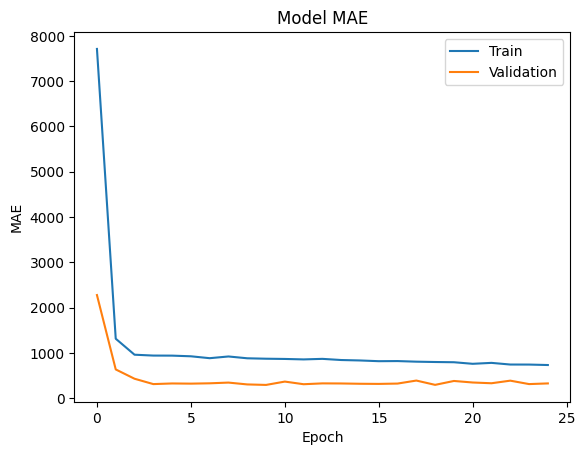

Minimum validation MAE: 293.5513
Minimum validation MAPE: 1.7259
plot_train shape: (855, 1)
plot_test shape: (205, 1)
plot_preds shape: (205, 1)


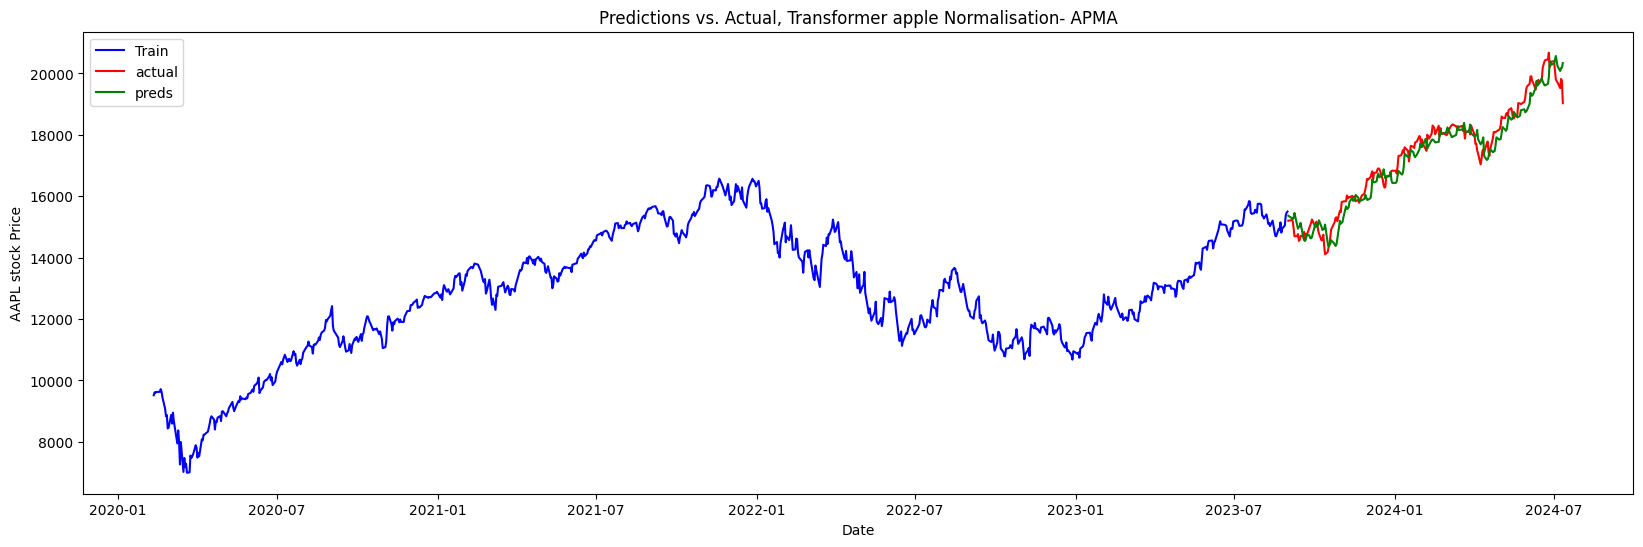

MAPE for APMA: 0.018582847657267136
RMSE for APMA: 395.346284764963
MAE for APMA: 319.03480282738093
R-squared for APMA: 0.9431898256165152
Done


In [10]:
n = 0
ticker = 'NDX'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]
while (n < 2):
    try:
        dataset.dropna(inplace=True)
        if n == 0:
            normaliza_bool_update = True
        else:
            normaliza_bool_update = False
        type_normalisation_update = MinMaxScaler()

        data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=True)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer apple Normalisation- {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
        if n == 1:
            print("Done")
        n += 1
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")